In [1]:
import lightgbm as lgb
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from itertools import product
import random

### Preprocess data

In [25]:
df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/generated_datasets/atp_features_0518.csv')
df = df.replace(' ', '_', regex=True)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Get rid of points where there is no first shot (< 3 rally shots)
df = df[df['first_shot_loc'] != 'no_first_shot']
print(len(df))

# Check if first/second serve by seeing if 'first_serve_attempt' is 'made_first_serve'
df['serve_type'] = df.apply(lambda row: 1 if row['first_serve_attempt'] == 'made_first_serve' else 2, axis=1)

# Create combination features
df['s+1'] = df['serve_loc'] + '_' + df['first_shot_loc']
df['side_s+1'] = df.apply(lambda row: f"{row['serve_loc']}_{row['first_shot_loc']}_{row['court_side']}", axis=1)
df['1st/2nd_s+1'] = df['serve_loc'] + '_' + df['first_shot_loc'] + '_' + df['serve_type'].astype(str) + '_' + df['court_side']
df['side_serve_loc'] = df['serve_loc'] + '_on_' + df['court_side']
df['side_first_shot_loc'] = df['first_shot_loc'] + '_on_' + df['court_side']
df['1st/2nd_serve_loc'] = df['serve_loc'] + '_on_' + df['court_side'] + '_' + df['serve_type'].astype(str)
df['1st/2nd_first_shot_loc'] = df['first_shot_loc'] + '_on_' + df['court_side'] + '_' + df['serve_type'].astype(str)
df['date'] = pd.to_datetime(df['match_id'].str.split('-').str[0], format='%Y%m%d', errors='coerce')

df_original = df.copy()

# Drop columns with high rate of missing values
df = df.drop(['server_bp_saved_recent_matches', 'returner_depth_recent_matches_1st/2nd', 'returner_depth_recent_matches_wide',
              'returner_depth_recent_matches_T', 'returner_depth_recent_matches_body'], axis=1)
df = df.dropna()
df = df[df['first_shot_loc'] != 'unknown']
df = df[df['first_serve_attempt'] != 'unknown']
df = df[df['serve_loc'] != 'unknown']
print(len(df))

399318
358650


In [26]:
def add_rolling_win_rates(df, n=5):
    """
    Add rolling win rates based on s+1, serve_loc, and first_shot_loc.
    """
    
    df = df.sort_values(by=['server', 'date']).copy()

    def compute_rolling_win_pct(df, group_col, prefix):
        summary = (
            df.groupby(['server', group_col, 'match_id'])
              .agg(total_pts=('won_pt', 'count'), won_pts=('won_pt', 'sum'))
              .reset_index()
        )
        summary['rolling_win_pct'] = (
            summary
            .groupby(['server', group_col])
            .apply(lambda g: g[['won_pts', 'total_pts']]
                   .shift()
                   .rolling(n, min_periods=1)
                   .sum()
                   .eval('won_pts / total_pts'))
            .reset_index(level=[0,1], drop=True)
        )
        pivoted = (
            summary.pivot(index=['server', 'match_id'], 
                          columns=group_col, 
                          values='rolling_win_pct')
                   .reset_index()
        )
        pivoted.columns = ['server', 'match_id'] + [f'{prefix}_{c}' for c in pivoted.columns[2:]]
        return pivoted

    # Compute for each feature
    s1_pivot = compute_rolling_win_pct(df, '1st/2nd_s+1', 'win_pct_s1')
    serve_loc_pivot = compute_rolling_win_pct(df, '1st/2nd_serve_loc', 'win_pct_serve')
    shot_loc_pivot = compute_rolling_win_pct(df, '1st/2nd_first_shot_loc', 'win_pct_first_shot')

    # Drop old win_pct_* columns if any
    df = df.drop(columns=[col for col in df.columns if col.startswith('win_pct_')], errors='ignore')

    # Merge all
    df = df.merge(s1_pivot, on=['server', 'match_id'], how='left')
    df = df.merge(serve_loc_pivot, on=['server', 'match_id'], how='left')
    df = df.merge(shot_loc_pivot, on=['server', 'match_id'], how='left')

    # Fill NaNs
    win_pct_cols = [col for col in df.columns if col.startswith('win_pct_')]
    df[win_pct_cols] = df[win_pct_cols].fillna(0.5)

    return df

In [27]:
df = add_rolling_win_rates(df)

done1
done2
done3


In [29]:
def add_interaction_features(df):
    """
    Add features based on interaction between categorical variables for locations
    for the serve and first shot.
    """

    df = df.copy()

    # Columns to one-hot encode
    one_hot_cols = [
        'surface', 'hand_combo', 'court_side', 'first_serve_attempt',
        'serve_loc', 'first_shot_loc', 'is_break_point', 's+1', 'side_serve_loc',
        'side_s+1', 'is_game_point', 'side_first_shot_loc', '1st/2nd_serve_loc', '1st/2nd_first_shot_loc',
        '1st/2nd_s+1'
    ]

    # Label encode server and opponent
    label_encoders = {}
    for col in ['server', 'opponent']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # One-hot encode categorical variables but keep the original columns
    for col in one_hot_cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)

    mean_return = df[['wide_returner_win_recent_matches', 
                    'body_returner_win_recent_matches',
                    'T_returner_win_recent_matches']].mean(axis=1)
        
    df['wide_return_advantage'] = df['serve_loc_wide'] * (df['wide_returner_win_recent_matches'] - mean_return)
    df['body_return_advantage'] = df['serve_loc_body'] * (df['body_returner_win_recent_matches'] - mean_return)
    df['T_return_advantage'] = df['serve_loc_t'] * (df['T_returner_win_recent_matches'] - mean_return)
    
    df['returner_success_on_this_serve_recent_matches'] = (
        df['serve_loc_wide'] * df['wide_return_advantage'] + 
        df['serve_loc_body'] * df['body_return_advantage'] +
        df['serve_loc_t'] * df['body_return_advantage']
    )

    df['interaction_returns_wide'] = df['serve_loc_wide'] * df['wide_returner_win_recent_matches']
    df['interaction_returns_body'] = df['serve_loc_body'] * df['body_returner_win_recent_matches']
    df['interaction_returns_T'] = df['serve_loc_t'] * df['T_returner_win_recent_matches']

    df['opponent_error_rate_from_+1_loc'] = (
        df['first_shot_loc_deuce_court'] * df['op_pct_errors_deuce_side'] + 
        df['first_shot_loc_ad_court'] * df['op_pct_errors_ad_side'] +
        df['first_shot_loc_middle'] * df['op_pct_errors_middle']
    )

    df['interaction_+1_deuce'] = df['first_shot_loc_deuce_court'] * df['op_pct_errors_deuce_side']
    df['interaction_+1_ad'] = df['first_shot_loc_ad_court'] * df['op_pct_errors_ad_side']
    df['opponent_error_rate_from_middle'] = df['first_shot_loc_middle'] * df['op_pct_errors_middle']

    df['opponent_pct_shots_are_errors_from_+1_loc'] = (
        df['first_shot_loc_deuce_court'] * df['op_pct_shots_errors_deuce_side'] + 
        df['first_shot_loc_ad_court'] * df['op_pct_shots_errors_ad_side'] +
        df['first_shot_loc_middle'] * df['op_pct_shots_errors_middle']
    )

    df['interaction_+1_deuce_shots'] = df['first_shot_loc_deuce_court'] * df['op_pct_shots_errors_deuce_side']
    df['interaction_+1_ad_shots'] = df['first_shot_loc_ad_court'] * df['op_pct_shots_errors_ad_side']
    df['interaction_+1_middle_shots'] = df['first_shot_loc_middle'] * df['op_pct_shots_errors_middle']
    
    df['rolling_server_success_on_this_serve'] = (
        df['serve_loc_wide'] * df['wide_server_win_rate'] +
        df['serve_loc_body'] * df['body_server_win_rate'] +
        df['serve_loc_t'] * df['T_server_win_rate']
    )

    mean_serve = df[['wide_server_win_rate', 'body_server_win_rate', 'T_server_win_rate']].mean(axis=1)

    df['interaction_serve_wide'] = df['serve_loc_wide'] * df['wide_server_win_rate']
    df['interaction_serve_body'] = df['serve_loc_body'] * df['body_server_win_rate']
    df['interaction_serve_T'] = df['serve_loc_t'] * df['T_server_win_rate']

    df['wide_server_advantage'] = df['serve_loc_wide'] * (df['wide_server_win_rate'] - mean_serve)
    df['body_server_advantage'] = df['serve_loc_body'] * (df['body_server_win_rate'] - mean_serve)
    df['T_server_advantage'] = df['serve_loc_t'] * (df['T_server_win_rate'] - mean_serve)

    df['gp_won_recent_matches'] = df['is_game_point_True'] * df['server_gp_won_recent_matches']
    df['s+1_success_rate_recent_matches'] = df.apply(lambda row: row[f'win_pct_s1_{row["1st/2nd_s+1"]}'], axis=1)
    df['serve_success_rate_recent_matches'] = df.apply(lambda row: row[f'win_pct_serve_{row["1st/2nd_serve_loc"]}'], axis=1)
    df['first_shot_success_rate_recent_matches'] = df.apply(lambda row: row[f'win_pct_first_shot_{row["1st/2nd_first_shot_loc"]}'], axis=1)

    return df, label_encoders

### Train / Eval Model

In [30]:
def eval_model(model, X, y):
    """
    Evaluate a model on a given dataset.
    """
    y_pred = model.predict(X)
    y_pred_label = (y_pred >= 0.50).astype(int)
    f1 = f1_score(y, y_pred_label)
    accuracy = accuracy_score(y, y_pred_label)
    precision = precision_score(y, y_pred_label, zero_division=0)
    recall = recall_score(y, y_pred_label, zero_division=0)
    return f1, accuracy, precision, recall

def eval_cumulative_f1(model, X, y):
    """
    Evaluate cumulative F1 score on a given dataset by points in match.
    """
    X_new = X
    dmatrix = xgb.DMatrix(X_new)

    # Convert to appropriate format for xgboost
    if isinstance(model, xgb.Booster):
        X_new = model.transform(dmatrix)

    pred_probs = model.predict(X_new)
    pred_labels = (pred_probs >= 0.5).astype(int)

    df = X.copy()
    df['true_label'] = y
    df['pred_prob'] = pred_probs
    df['pred_label'] = pred_labels

    df = df.sort_values('pts_in_match')
    unique_pts = sorted(df['pts_in_match'].unique())

    results = []
    for pt in unique_pts:
        subset = df[df['pts_in_match'] <= pt]
        if len(subset) < 10:
            continue
        f1 = f1_score(subset['true_label'], subset['pred_label'], zero_division=0)
        results.append({
            'pts_in_match': pt,
            'num_samples': len(subset),
            'f1_score': f1
        })

    return pd.DataFrame(results)

def train_and_eval_model(X_train, X_val, y_train, y_val, scaled = True, class_imbalance = True, global_model = None):
    """Train and evaluate a LightGBM model."""
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)
    scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
    sample_weights = np.where(y_train == 1, scale_weight, 1.0)
    if scaled:
        train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights)

    params = {
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1,
        'metric': ['binary_logloss'],
        'max_depth': 5,
    }

    if global_model is None:
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train', 'valid'],
            num_boost_round=100,
        )
    else:
        model = global_model

    X_val_first_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 1]
    y_val_first_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 1]

    X_val_second_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 0]
    y_val_second_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 0]

    f1_1, accuracy_1, precision_1, recall_1 = eval_model(model, X_val_first_serve, y_val_first_serve)

    f1_2, accuracy_2, precision_2, recall_2 = eval_model(model, X_val_second_serve, y_val_second_serve)

    f1, accuracy, precision, recall = eval_model(model, X_val, y_val)

    return model, (f1, accuracy, precision, recall), (f1_1, accuracy_1, precision_1, recall_1), (f1_2, accuracy_2, precision_2, recall_2)

def train_and_eval_model_lr(X_train, X_val, y_train, y_val, scaled=False, class_imbalance=False, global_model=None):
    """Train and evaluate a Logistic Regression model."""

    if scaled and class_imbalance:
        scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
        sample_weights = np.where(y_train == 1, scale_weight, 1.0)
    else:
        sample_weights = None

    if global_model is None:
        model = LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            class_weight='balanced' if class_imbalance else None
        )
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model = global_model

    # Split by first vs second serve
    X_val_first_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 1]
    y_val_first_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 1]

    X_val_second_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 0]
    y_val_second_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 0]

    f1_1, accuracy_1, precision_1, recall_1 = eval_model(model, X_val_first_serve, y_val_first_serve)
    f1_2, accuracy_2, precision_2, recall_2 = eval_model(model, X_val_second_serve, y_val_second_serve)
    f1, accuracy, precision, recall = eval_model(model, X_val, y_val)

    return model, (f1, accuracy, precision, recall), (f1_1, accuracy_1, precision_1, recall_1), (f1_2, accuracy_2, precision_2, recall_2)

def train_and_eval_model_xgb(X_train, X_val, y_train, y_val, class_imbalance=False, global_model=None):
    """Train and evaluate a XGBoost model."""

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'binary:logistic',   # You want probability outputs
        'eval_metric': 'logloss',          
        'learning_rate': 0.01,             
        'max_depth': 5,                    
        'min_child_weight': 3,           
        'subsample': 0.75,             
        'colsample_bytree': 0.75,          
        'lambda': 1.0,                   
        'alpha': 0.1,
        'grow_policy': 'lossguide',         # Alternative splitting strategy
        'class_weight': 'balanced' if class_imbalance else None,
        'verbosity': 0,            
    }

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    if global_model is None:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=watchlist,
            verbose_eval=50,
            early_stopping_rounds=50
        )
    else:
        model = global_model

    # Evaluate separately for first and second serves
    X_val_first_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 1]
    y_val_first_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 1]

    X_val_second_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 0]
    y_val_second_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 0]

    f1_1, accuracy_1, precision_1, recall_1 = eval_model(model, xgb.DMatrix(X_val_first_serve), y_val_first_serve)
    f1_2, accuracy_2, precision_2, recall_2 = eval_model(model, xgb.DMatrix(X_val_second_serve), y_val_second_serve)
    f1, accuracy, precision, recall = eval_model(model, dvalid, y_val)

    return model, (f1, accuracy, precision, recall), (f1_1, accuracy_1, precision_1, recall_1), (f1_2, accuracy_2, precision_2, recall_2)

In [32]:
def model_results(df_preprocessed, player, feature_cols, target_cols, type, year, results = None, global_model = None): 
    """Store results of model training and evaluation."""

    df_train = df_preprocessed[df_preprocessed[f'data_split_{year}'] == 'train'].drop(['data_split_2024'], axis=1)
    df_test = df_preprocessed[df_preprocessed[f'data_split_{year}'] == 'test'].drop(['data_split_2024'], axis=1)
    X_train, X_val = df_train[feature_cols], df_test[feature_cols]
    y_train, y_val = df_train[target_cols].astype(float), df_test[target_cols].astype(float)
    y_train = y_train.squeeze()
    y_val = y_val.squeeze()

    # Print number of features of X_train
    print(f'X_train shape: {X_train.shape}')

    model, total, fs, ss = train_and_eval_model(X_train, X_val, y_train, y_val, False, global_model=global_model)
    results[player][type]['class_imbalance'] = [total, fs, ss]

    return model, X_val, y_val, df_test

In [34]:
def find_players_many_points(df, year):
    """
    Find players with at least x points in train and y points in test.
    """
    df_res = df.groupby('server').filter(lambda x: (x[f'data_split_{year}'] == 'train').sum() > 3650 and (x[f'data_split_{year}'] == 'test').sum() > 100)
    return df_res['server'].unique()

yr_split = 2024
players_lst = find_players_many_points(df, yr_split)

players_map_atp= {'alexander_zverev': 7, 'andrey_rublev': 5, 'andy_murray': 42,
       'botic_van_de_zandschulp': 50, 'carlos_alcaraz': 2, 'casper_ruud': 11,
       'daniil_medvedev': 3, 'dominic_thiem': 98, 'grigor_dimitrov': 14,
       'hubert_hurkacz': 9, 'jannik_sinner': 4, 'novak_djokovic': 1,
       'rafael_nadal': 672, 'stan_wawrinka': 49, 'stefanos_tsitsipas': 6}


players_map_wta = {'angelique_kerber': 999, 'arantxa_rus': 51, 'bianca_andreescu': 100,
       'caroline_wozniacki': 72, 'coco_gauff': 3, 'daria_kasatkina': 18,
       'elena_rybakina': 4, 'elina_svitolina': 14, 'iga_swiatek': 1,
       'karolina_muchova': 9, 'karolina_pliskova': 39, 'maria_sakkari': 8,
       'naomi_osaka': 49, 'sofia_kenin': 37, 'victoria_azarenka': 23}

print("Rankings: ", sorted([val for val in players_map_atp.values()]))

players_lst

Rankings:  [1, 2, 3, 4, 5, 6, 7, 9, 11, 14, 42, 49, 50, 98, 672]


array(['alexander_zverev', 'andrey_rublev', 'andy_murray',
       'botic_van_de_zandschulp', 'carlos_alcaraz', 'casper_ruud',
       'daniil_medvedev', 'dominic_thiem', 'grigor_dimitrov',
       'hubert_hurkacz', 'jannik_sinner', 'novak_djokovic',
       'rafael_nadal', 'stan_wawrinka', 'stefanos_tsitsipas'],
      dtype=object)

In [35]:
results = defaultdict(lambda : defaultdict(lambda: defaultdict(list))) # defaultdict

In [36]:
def shannon_entropy(sequence):
    if len(sequence) == 0:
        return np.nan

    counts = Counter(sequence)
    total = sum(counts.values())
    probs = [count / total for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs)

    max_entropy = np.log2(len(counts)) if len(counts) > 1 else 1
    return entropy / max_entropy

def combine_player_entropies(df, player, column):
    df_train_player = df[(df['data_split_2024'] == 'train') & (df['server'] == player)]

    fs_entropies, fs_weights = [], []
    ss_entropies, ss_weights = [], []

    for match_id in df_train_player['match_id'].unique():
        df_match = df_train_player[df_train_player['match_id'] == match_id]

        segments = {
            'deuce_first': df_match[(df_match['first_serve_attempt'] == 'made_first_serve') & (df_match['court_side'] == 'deuce')],
            'ad_first':    df_match[(df_match['first_serve_attempt'] == 'made_first_serve') & (df_match['court_side'] == 'ad')],
            'deuce_second':df_match[(df_match['first_serve_attempt'] != 'made_first_serve') & (df_match['court_side'] == 'deuce')],
            'ad_second':   df_match[(df_match['first_serve_attempt'] != 'made_first_serve') & (df_match['court_side'] == 'ad')],
        }

        for key, subset in segments.items():
            if not subset.empty:
                entropy = shannon_entropy(subset[column])
                if entropy > 0:
                    n_points = len(subset)
                    if 'first' in key:
                        fs_entropies.append(entropy)
                        fs_weights.append(n_points)
                    else:
                        ss_entropies.append(entropy)
                        ss_weights.append(n_points)

    # Weighted means
    fs_mean = np.average(fs_entropies, weights=fs_weights) if fs_weights else np.nan
    ss_mean = np.average(ss_entropies, weights=ss_weights) if ss_weights else np.nan
    overall_mean = np.average([fs_mean, ss_mean], weights=[len(fs_entropies), len(ss_entropies)])

    return fs_mean, ss_mean, overall_mean

In [37]:
def evaluate_single_player(df_player, player, year, global_model_basic = None, global_model_complex = None):

    print("Training data Points: ", len(df_player[df_player[f'data_split_{year}'] == 'train']), "Testing data Points: ", len(df_player[df_player[f'data_split_{year}'] == 'test']))
    print("Training matches: ", df_player[df_player[f'data_split_{year}'] == 'train']['match_id'].nunique(), "Testing matches: ", df_player[df_player[f'data_split_{year}'] == 'test']['match_id'].nunique())

    df_preprocessed, _ = add_interaction_features(df_player)

    categorical_cols = []

    # After one-hot encoding, collect all new columns
    one_hot_prefixes_basic = ['side_serve_loc_', 'first_shot_loc_', 'surface_']
    one_hot_prefixes_complex =  ['side_serve_loc_', 'first_shot_loc_', 'surface_']

    numerical_cols_basic = [col for col in df_preprocessed.columns if any(col.startswith(prefix) for prefix in one_hot_prefixes_basic)] + [
        'first_serve_attempt_made_first_serve',
        'court_side_deuce',
    ]

    numerical_cols_complex = [col for col in df_preprocessed.columns if any(col.startswith(prefix) for prefix in one_hot_prefixes_complex)] + [
        'is_break_point_True',
        'is_game_point_True',
        'first_serve_attempt_made_first_serve',
        'court_side_deuce',
        'point_advantage',
        'set_advantage',
        'game_advantage',
        'pts_in_match',
        'win_streak_server',
        'height',
        'height_difference',
        '1st/2nd_server_win_rate',
        'returner_win_1st/2nd_recent_matches',
        'same_serve_last',
        'same_shot_last',
        's1_success_rate_whole_match',
        'good_pts_server_minus_opp',
        'wide_return_advantage', 'body_return_advantage', 'T_return_advantage',
        'interaction_+1_deuce', 'interaction_+1_ad', 'opponent_error_rate_from_middle',
        'interaction_serve_wide', 'interaction_serve_body', 'interaction_serve_T',
        'gp_won_recent_matches',
        's+1_success_rate_recent_matches',
        'serve_success_rate_recent_matches',
    ]

    target_cols = ['won_pt']

    feature_cols_basic = categorical_cols + numerical_cols_basic
    feature_cols_complex = categorical_cols + numerical_cols_complex

    print('Basic -----')
    basic_model, basic_X, _, _ = model_results(df_preprocessed, player, feature_cols_basic, target_cols, 'basic', year, results, global_model_basic)
    print('Complex -----')
    complex_model, complex_X, _, df_test = model_results(df_preprocessed, player, feature_cols_complex, target_cols, 'complex', year, results, global_model_complex)


    return basic_model, complex_model, feature_cols_basic, feature_cols_complex, basic_X, complex_X, df_test

In [ ]:
# Evaluate all players
models = defaultdict(dict)

df_player_all = df[(df['server'].isin(players_lst))]

# TODO: Uncomment this line if training global model
# global_model_basic, global_model_complex, _, _, _, _, _ = evaluate_single_player(df_player_all, 'all', yr_split)

for player in players_lst:
    df_player_orig = df_original[df_original['server'] == player]
    df_player_orig_wonpt = df_original[((df_original['server'] == player) | (df_original['opponent'] == player)) & (df_original['won_pt'] == 1)]
    df_player = df[(df['server'] == player)]
    fs_entropy_serve, ss_entropy_serve, entropy_serve = combine_player_entropies(df_player_orig, player, 'serve_loc')
    fs_entropy_1, ss_entropy_1, entropy_1 = combine_player_entropies(df_player, player, 'first_shot_loc')
    fs_entropy_combo, ss_entropy_combo, entropy_combo = combine_player_entropies(df_player, player, 's+1')

    basic_model, complex_model, feature_cols_basic, feature_cols_complex, basic_X, complex_X, df_test_raw = evaluate_single_player(df_player, player, yr_split)
    models[player]['basic'] = basic_model
    models[player]['complex'] = complex_model
    models[player]['train_data_pts'] = len(df_player[df_player[f'data_split_{yr_split}'] == 'train'])
    models[player]['test_data_pts'] = len(df_player[df_player[f'data_split_{yr_split}'] == 'test'])
    models[player]['test_data_pts_fs'] = len(df_player[(df_player[f'data_split_{yr_split}'] == 'test') & (df_player['first_serve_attempt'] == 'made_first_serve')])
    models[player]['test_data_pts_ss'] = len(df_player[(df_player[f'data_split_{yr_split}'] == 'test') & (df_player['first_serve_attempt'] != 'made_first_serve')])
    models[player]['fs_win_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] == 'made_first_serve')]['won_pt'].sum() / len(df_player[(df_player[f'data_split_{yr_split}'] == 'train') & (df_player['first_serve_attempt'] == 'made_first_serve')]))
    models[player]['ss_win_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] != 'made_first_serve')]['won_pt'].sum() / len(df_player[(df_player[f'data_split_{yr_split}'] == 'train') & (df_player['first_serve_attempt'] != 'made_first_serve')]))
    models[player]['overall_win_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train')]['won_pt'].sum() / len(df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train')]))
    models[player]['fs_success_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] == 'made_first_serve')]['s1_success'].sum() / len(df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] == 'made_first_serve')]))
    models[player]['ss_success_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] != 'made_first_serve')]['s1_success'].sum() / len(df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train') & (df_player_orig['first_serve_attempt'] != 'made_first_serve')]))
    models[player]['overall_s1_success_rate'] = (df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train')]['s1_success'].sum() / len(df_player_orig[(df_player_orig[f'data_split_{yr_split}'] == 'train')]))
    models[player]['fs_predictability'] = fs_entropy_serve
    models[player]['ss_predictability'] = ss_entropy_serve
    models[player]['serve_predictability'] = entropy_serve
    models[player]['fs_predictability_+1'] = fs_entropy_1
    models[player]['ss_predictability_+1'] = ss_entropy_1
    models[player]['predictability_+1'] = entropy_1
    models[player]['fs_predictability_combo'] = fs_entropy_combo
    models[player]['ss_predictability_combo'] = ss_entropy_combo
    models[player]['predictability_combo'] = entropy_combo
    models[player]['rally_length'] = df_player_orig_wonpt['rally_length'].sum() / len(df_player_orig_wonpt)
    models[player]['fs_rally_length'] = df_player_orig_wonpt[(df_player_orig_wonpt['first_serve_attempt'] == 'made_first_serve')]['rally_length'].sum() / len(df_player_orig_wonpt[(df_player_orig_wonpt['first_serve_attempt'] == 'made_first_serve')])
    models[player]['ss_rally_length'] = df_player_orig_wonpt[(df_player_orig_wonpt['first_serve_attempt'] != 'made_first_serve')]['rally_length'].sum() / len(df_player_orig_wonpt[(df_player_orig_wonpt['first_serve_attempt'] != 'made_first_serve')])
    models[player]['df_test'] = df_test_raw
    models[player]['basic_val_set'] = basic_X
    models[player]['complex_val_set'] = complex_X

In [39]:
def compare_results(results, model_type):
    f1_lift_scaled, acc_lift_scaled, prec_lift_scaled, rec_lift_scaled = [], [], [], []
    f1_lift_scaled_fs, acc_lift_scaled_fs, prec_lift_scaled_fs, rec_lift_scaled_fs = [], [], [], []
    f1_lift_scaled_ss, acc_lift_scaled_ss, prec_lift_scaled_ss, rec_lift_scaled_ss = [], [], [], []

    all_complex_f1, all_complex_acc, all_complex_prec, all_complex_rec = [], [], [], []
    all_complex_f1_fs, all_complex_acc_fs, all_complex_prec_fs, all_complex_rec_fs = [], [], [], []
    all_complex_f1_ss, all_complex_acc_ss, all_complex_prec_ss, all_complex_rec_ss = [], [], [], []

    num_data_pts = []
    num_data_pts_fs = []
    num_data_pts_ss = []

    for player in results:
        if player == 'all':
            continue

        n_pts = models[player]['test_data_pts']
        n_pts_fs = models[player]['test_data_pts_fs']
        n_pts_ss = models[player]['test_data_pts_ss']

        num_data_pts.append(n_pts)
        num_data_pts_fs.append(n_pts_fs)
        num_data_pts_ss.append(n_pts_ss)

        player_res = results[player]

        basic_f1, basic_acc, basic_prec, basic_rec = player_res['basic'][model_type][0]
        basic_f1_fs, basic_acc_fs, basic_prec_fs, basic_rec_fs = player_res['basic'][model_type][1]
        basic_f1_ss, basic_acc_ss, basic_prec_ss, basic_rec_ss = player_res['basic'][model_type][2]

        complex_f1, complex_acc, complex_prec, complex_rec = player_res['complex'][model_type][0]
        complex_f1_fs, complex_acc_fs, complex_prec_fs, complex_rec_fs = player_res['complex'][model_type][1]
        complex_f1_ss, complex_acc_ss, complex_prec_ss, complex_rec_ss = player_res['complex'][model_type][2]

        f1_lift_scaled.append(complex_f1 - basic_f1)
        acc_lift_scaled.append(complex_acc - basic_acc)
        prec_lift_scaled.append(complex_prec - basic_prec)
        rec_lift_scaled.append(complex_rec - basic_rec)

        f1_lift_scaled_fs.append(complex_f1_fs - basic_f1_fs)
        acc_lift_scaled_fs.append(complex_acc_fs - basic_acc_fs)
        prec_lift_scaled_fs.append(complex_prec_fs - basic_prec_fs)
        rec_lift_scaled_fs.append(complex_rec_fs - basic_rec_fs)

        f1_lift_scaled_ss.append(complex_f1_ss - basic_f1_ss)
        acc_lift_scaled_ss.append(complex_acc_ss - basic_acc_ss)
        prec_lift_scaled_ss.append(complex_prec_ss - basic_prec_ss)
        rec_lift_scaled_ss.append(complex_rec_ss - basic_rec_ss)

        all_complex_f1.append(complex_f1)
        all_complex_acc.append(complex_acc)
        all_complex_prec.append(complex_prec)
        all_complex_rec.append(complex_rec)

        all_complex_f1_fs.append(complex_f1_fs)
        all_complex_acc_fs.append(complex_acc_fs)
        all_complex_prec_fs.append(complex_prec_fs)
        all_complex_rec_fs.append(complex_rec_fs)

        all_complex_f1_ss.append(complex_f1_ss)
        all_complex_acc_ss.append(complex_acc_ss)
        all_complex_prec_ss.append(complex_prec_ss)
        all_complex_rec_ss.append(complex_rec_ss)

    # Print weighted lifts
    print('Weighted Lift in (F1, Accuracy, Precision, Recall):',
          tuple(round(x, 3) for x in np.average([f1_lift_scaled, acc_lift_scaled, prec_lift_scaled, rec_lift_scaled], weights=num_data_pts, axis=1)))

    print('Weighted First Serve Lift:',
          tuple(round(x, 3) for x in np.average([f1_lift_scaled_fs, acc_lift_scaled_fs, prec_lift_scaled_fs, rec_lift_scaled_fs], weights=num_data_pts_fs, axis=1)))

    print('Weighted Second Serve Lift:',
          tuple(round(x, 3) for x in np.average([f1_lift_scaled_ss, acc_lift_scaled_ss, prec_lift_scaled_ss, rec_lift_scaled_ss], weights=num_data_pts_ss, axis=1)))

    # Print weighted absolute metrics for complex models
    print('Weighted Complex Model (F1, Accuracy, Precision, Recall):',
          tuple(round(x, 3) for x in np.average([all_complex_f1, all_complex_acc, all_complex_prec, all_complex_rec], weights=num_data_pts, axis=1)))

    print('Weighted Complex First Serve:',
          tuple(round(x, 3) for x in np.average([all_complex_f1_fs, all_complex_acc_fs, all_complex_prec_fs, all_complex_rec_fs], weights=num_data_pts_fs, axis=1)))

    print('Weighted Complex Second Serve:',
          tuple(round(x, 3) for x in np.average([all_complex_f1_ss, all_complex_acc_ss, all_complex_prec_ss, all_complex_rec_ss], weights=num_data_pts_ss, axis=1)))

In [40]:
compare_results(results, 'class_imbalance')

Weighted Lift in (F1, Accuracy, Precision, Recall): (0.003, 0.003, 0.002, 0.004)
Weighted First Serve Lift: (0.001, 0.002, 0.001, 0.0)
Weighted Second Serve Lift: (0.008, 0.005, 0.004, 0.01)
Weighted Complex Model (F1, Accuracy, Precision, Recall): (0.708, 0.587, 0.596, 0.876)
Weighted Complex First Serve: (0.749, 0.617, 0.626, 0.935)
Weighted Complex Second Serve: (0.633, 0.544, 0.54, 0.773)


### Results Analysis: F1 Lift

No handles with labels found to put in legend.


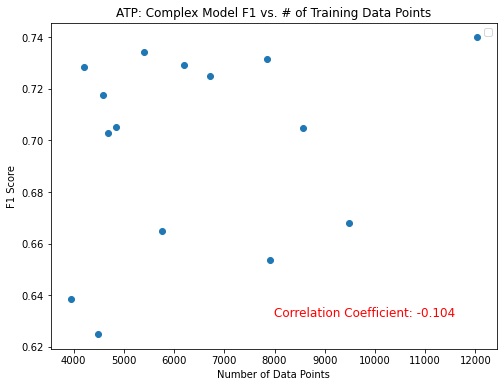

In [41]:
# Plot F1 vs. # of training data points
plt.figure(figsize=(8, 6))

plt.scatter([models[x]['train_data_pts'] for x in models], [results[x]['complex']['class_imbalance'][0][0] for x in results], marker='o')
correlation = np.corrcoef([models[x]['train_data_pts'] for x in models], [results[x]['complex']['class_imbalance'][0][0] for x in results])[0][1]
spearman_correlation, p_val = spearmanr([models[x]['train_data_pts'] for x in models], [results[x]['complex']['class_imbalance'][0][1] for x in results])
plt.text(0.5, 0.1, f"Correlation Coefficient: {spearman_correlation:.3f}", transform=plt.gca().transAxes, color='red', fontsize=12)

plt.title('ATP: Complex Model F1 vs. # of Training Data Points')
plt.xlabel('Number of Data Points')
plt.ylabel('F1 Score')
plt.show()

<Figure size 576x432 with 0 Axes>

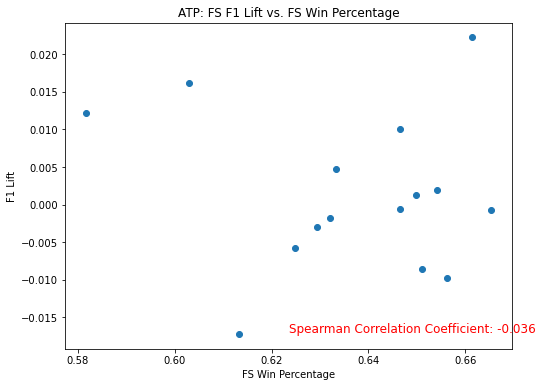

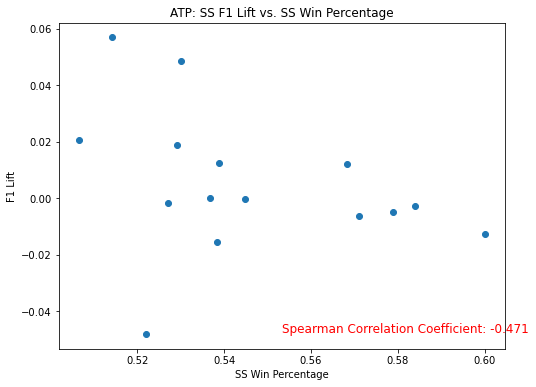

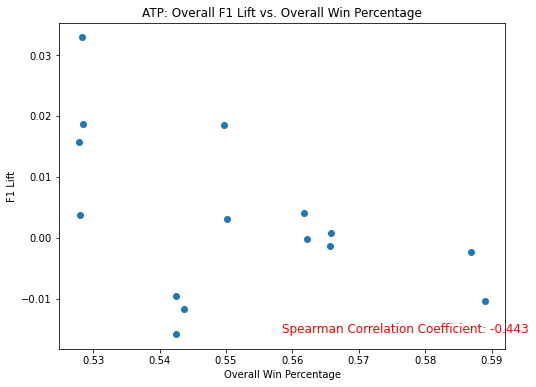

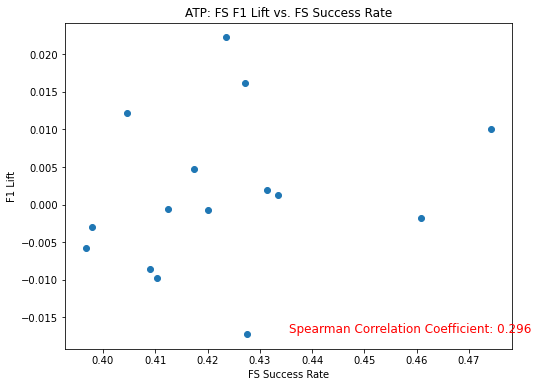

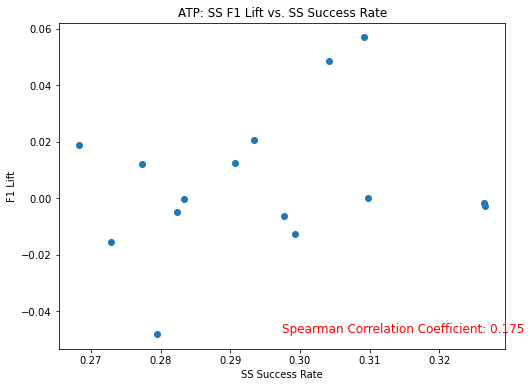

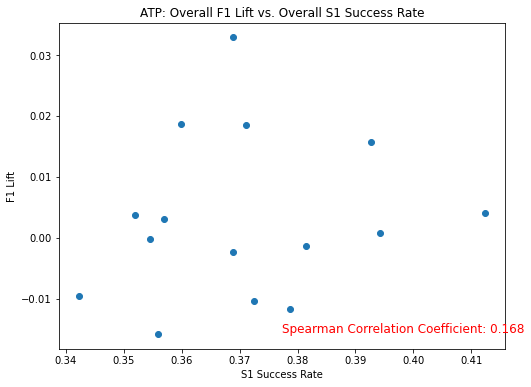

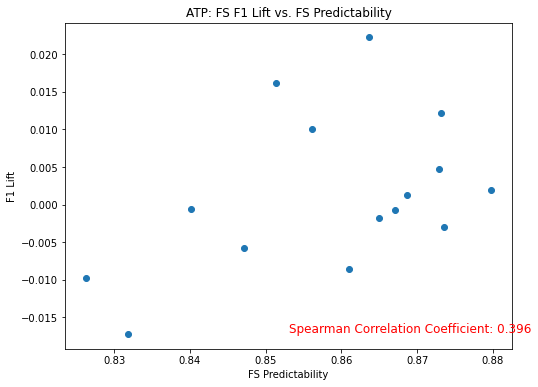

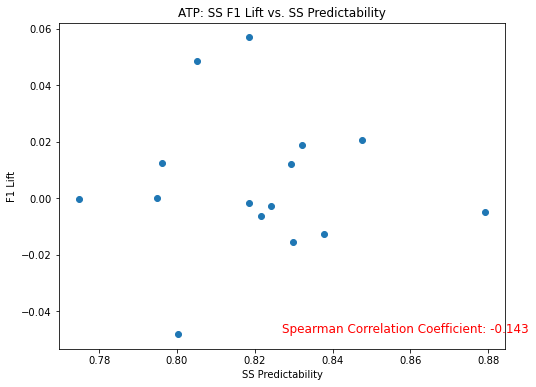

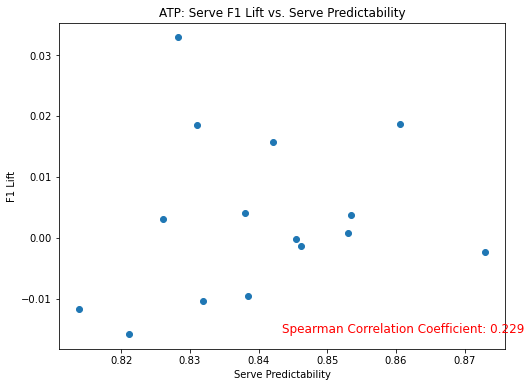

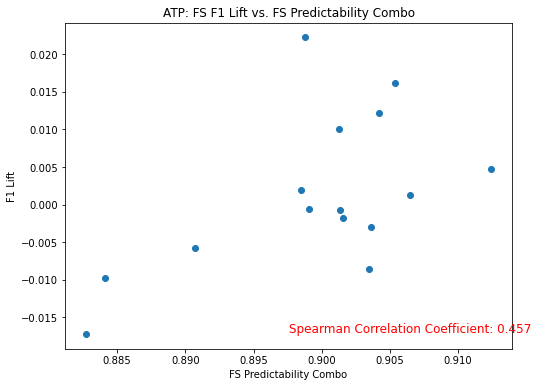

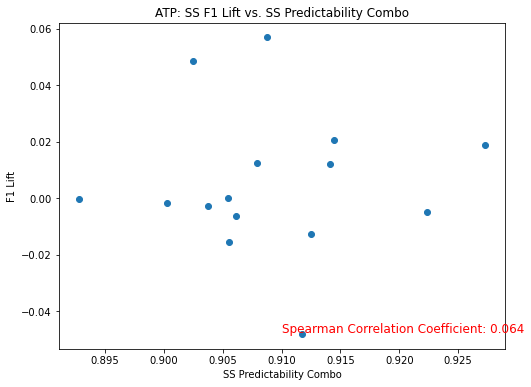

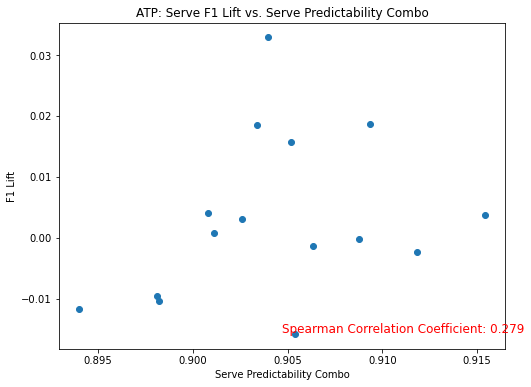

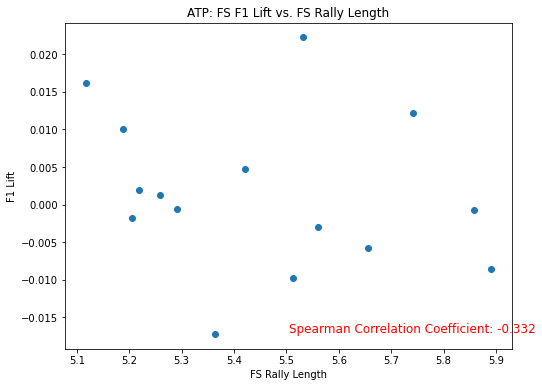

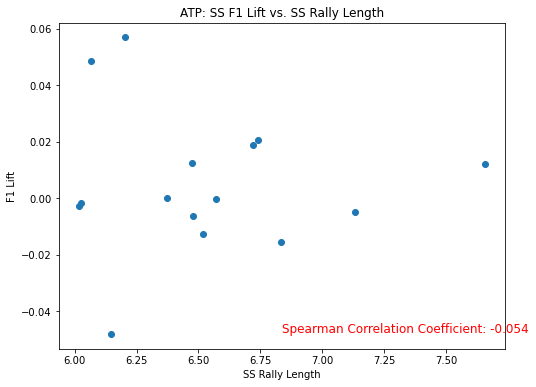

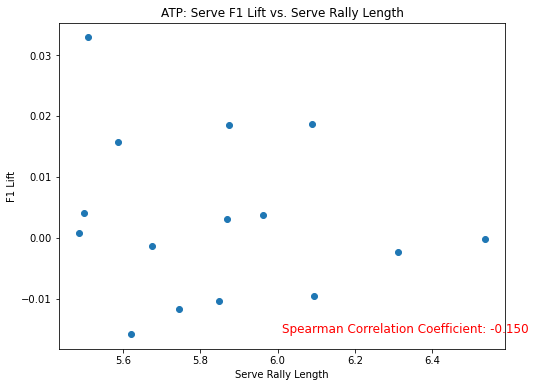

In [42]:
# Plot F1 Lift for FS vs. FS win percentage
league = 'ATP'

plt.figure(figsize=(8, 6))

f1_lift_overall_win_rate = [(models[x]['overall_win_rate'], results[x]['complex']['class_imbalance'][0][0] - results[x]['basic']['class_imbalance'][0][0]) for x in results]
f1_lift_fs_win_rate = [(models[x]['fs_win_rate'], results[x]['complex']['class_imbalance'][1][0] - results[x]['basic']['class_imbalance'][1][0]) for x in results]
f1_lift_ss_win_rate = [(models[x]['ss_win_rate'], results[x]['complex']['class_imbalance'][2][0] - results[x]['basic']['class_imbalance'][2][0]) for x in results]

f1_lift_s1_success = [(models[x]['overall_s1_success_rate'], results[x]['complex']['class_imbalance'][0][0] - results[x]['basic']['class_imbalance'][0][0]) for x in results]
f1_lift_fs_success = [(models[x]['fs_success_rate'], results[x]['complex']['class_imbalance'][1][0] - results[x]['basic']['class_imbalance'][1][0]) for x in results]
f1_lift_ss_success = [(models[x]['ss_success_rate'], results[x]['complex']['class_imbalance'][2][0] - results[x]['basic']['class_imbalance'][2][0]) for x in results]

f1_lift_fs_predictability = [(models[x]['fs_predictability'], results[x]['complex']['class_imbalance'][1][0] - results[x]['basic']['class_imbalance'][1][0]) for x in results]
f1_lift_ss_predictability = [(models[x]['ss_predictability'], results[x]['complex']['class_imbalance'][2][0] - results[x]['basic']['class_imbalance'][2][0]) for x in results]
f1_list_serve_predictability = [(models[x]['serve_predictability'], results[x]['complex']['class_imbalance'][0][0] - results[x]['basic']['class_imbalance'][0][0]) for x in results]

f1_lift_fs_predictability_combo = [(models[x]['fs_predictability_combo'], results[x]['complex']['class_imbalance'][1][0] - results[x]['basic']['class_imbalance'][1][0]) for x in results]
f1_lift_ss_predictability_combo = [(models[x]['ss_predictability_combo'], results[x]['complex']['class_imbalance'][2][0] - results[x]['basic']['class_imbalance'][2][0]) for x in results]
f1_list_serve_predictability_combo = [(models[x]['predictability_combo'], results[x]['complex']['class_imbalance'][0][0] - results[x]['basic']['class_imbalance'][0][0]) for x in results]

f1_lift_fs_rally_length = [(models[x]['fs_rally_length'], results[x]['complex']['class_imbalance'][1][0] - results[x]['basic']['class_imbalance'][1][0]) for x in results]
f1_lift_ss_rally_length = [(models[x]['ss_rally_length'], results[x]['complex']['class_imbalance'][2][0] - results[x]['basic']['class_imbalance'][2][0]) for x in results]
f1_list_rally_length = [(models[x]['rally_length'], results[x]['complex']['class_imbalance'][0][0] - results[x]['basic']['class_imbalance'][0][0]) for x in results]

def plot_f1_lift(data, title, xlabel, ylabel):    
    x_values = [x[0] for x in data]
    y_values = [x[1] for x in data]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, marker='o')
    
    spearman_correlation, _ = spearmanr(x_values, y_values)
    plt.text(0.5, 0.05, f"Spearman Correlation Coefficient: {spearman_correlation:.3f}", transform=plt.gca().transAxes, color='red', fontsize=12)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_f1_lift(f1_lift_fs_win_rate, f'{league}: FS F1 Lift vs. FS Win Percentage', 'FS Win Percentage', 'F1 Lift')
plot_f1_lift(f1_lift_ss_win_rate, f'{league}: SS F1 Lift vs. SS Win Percentage', 'SS Win Percentage', 'F1 Lift')
plot_f1_lift(f1_lift_overall_win_rate, f'{league}: Overall F1 Lift vs. Overall Win Percentage', 'Overall Win Percentage', 'F1 Lift')

plot_f1_lift(f1_lift_fs_success, f'{league}: FS F1 Lift vs. FS Success Rate', 'FS Success Rate', 'F1 Lift')
plot_f1_lift(f1_lift_ss_success, f'{league}: SS F1 Lift vs. SS Success Rate', 'SS Success Rate', 'F1 Lift')
plot_f1_lift(f1_lift_s1_success, f'{league}: Overall F1 Lift vs. Overall S1 Success Rate', 'S1 Success Rate', 'F1 Lift')

plot_f1_lift(f1_lift_fs_predictability, f'{league}: FS F1 Lift vs. FS Predictability', 'FS Predictability', 'F1 Lift')
plot_f1_lift(f1_lift_ss_predictability, f'{league}: SS F1 Lift vs. SS Predictability', 'SS Predictability', 'F1 Lift')
plot_f1_lift(f1_list_serve_predictability, f'{league}: Serve F1 Lift vs. Serve Predictability', 'Serve Predictability', 'F1 Lift')

plot_f1_lift(f1_lift_fs_predictability_combo, f'{league}: FS F1 Lift vs. FS Predictability Combo', 'FS Predictability Combo', 'F1 Lift')
plot_f1_lift(f1_lift_ss_predictability_combo, f'{league}: SS F1 Lift vs. SS Predictability Combo', 'SS Predictability Combo', 'F1 Lift')
plot_f1_lift(f1_list_serve_predictability_combo, f'{league}: Serve F1 Lift vs. Serve Predictability Combo', 'Serve Predictability Combo', 'F1 Lift')

plot_f1_lift(f1_lift_fs_rally_length, f'{league}: FS F1 Lift vs. FS Rally Length', 'FS Rally Length', 'F1 Lift')
plot_f1_lift(f1_lift_ss_rally_length, f'{league}: SS F1 Lift vs. SS Rally Length', 'SS Rally Length', 'F1 Lift')
plot_f1_lift(f1_list_rally_length, f'{league}: Serve F1 Lift vs. Serve Rally Length', 'Serve Rally Length', 'F1 Lift')

### Results Analysis: Feature Importance

In [484]:
def compare_f1_and_shap(models, results):
    """
    For each player:
    - Plot cumulative F1 score vs. # points in match for 'basic' and 'complex' models.
    - Show SHAP top 5 features for 'complex' model.
    """
    for player in results:
        if player == 'all':
            continue

        # Get F1 curves
        df_basic = results[player]['basic']['class_imbalance'][3][0]
        df_complex = results[player]['complex']['class_imbalance'][3][0]

        # Create subplots: 2 rows (F1 curve + SHAP), 1 column
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        player_name = player.replace('_', ' ').title()
        fig.suptitle("Player: " + player_name, fontsize=16)

        # Row 1: F1 curves
        axs[0].plot(df_complex['pts_in_match'], df_complex['f1_score'], marker='o', label='Complex', markersize=3, color='red')
        axs[0].plot(df_basic['pts_in_match'], df_basic['f1_score'], marker='o', label='Basic', markersize=3, color='blue')
        axs[0].set_xlabel('# Points in Match')
        axs[0].set_ylabel('Cumulative F1 Score')
        axs[0].set_title('Cumulative F1 Score vs # Points in Match')
        axs[0].legend()
        axs[0].grid(True)

        # Row 2: SHAP
        model = models[player]['complex']
        X_val = models[player]['complex_val_set']

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_val)
        shap_df = pd.DataFrame(shap_values, columns=X_val.columns)
        mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False).head(5)

        axs[1].barh(mean_abs_shap.index[::-1], mean_abs_shap.values[::-1])
        axs[1].set_title("Top 5 SHAP Features (Complex Model)")
        axs[1].set_xlabel("Mean |SHAP value|")
        axs[1].set_xlim(left=0)

        plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
        plt.show()

In [485]:
def plot_top5_shap_features_all_players(models):
    """
    Aggregate SHAP values across all players and plot top 5 most important features for complex models.
    """
    feature_shap_sums = defaultdict(float)
    feature_counts = defaultdict(int)

    for player in models:
        if player == 'all':
            continue

        model = models[player]['complex']
        X_val = models[player]['complex_val_set']

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_val)
        shap_df = pd.DataFrame(shap_values, columns=X_val.columns)

        # Accumulate mean absolute SHAP values
        mean_abs_shap = shap_df.abs().mean()
        for feature, value in mean_abs_shap.items():
            feature_shap_sums[feature] += value
            feature_counts[feature] += 1

    # Average SHAP across players
    avg_shap = {feature: feature_shap_sums[feature] / feature_counts[feature]
                for feature in feature_shap_sums}
    
    shap_series = pd.Series(avg_shap).sort_values(ascending=False).head(5)

    plt.figure(figsize=(8, 5))
    plt.barh(shap_series.index[::-1], shap_series.values[::-1])
    plt.title("ATP: Top 5 SHAP Features Across All Players (Complex Models)")
    plt.xlabel("Mean |SHAP Value|")
    plt.xlim(left=0)
    plt.tight_layout()
    plt.show()

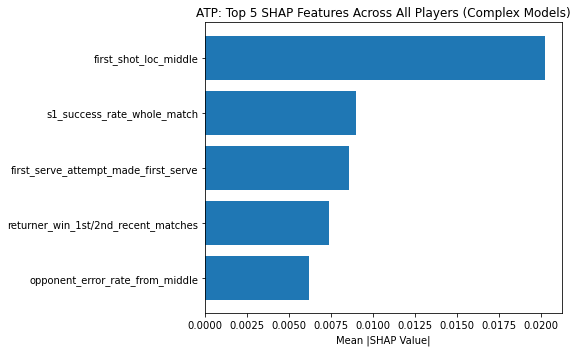

In [486]:
plot_top5_shap_features_all_players(models)

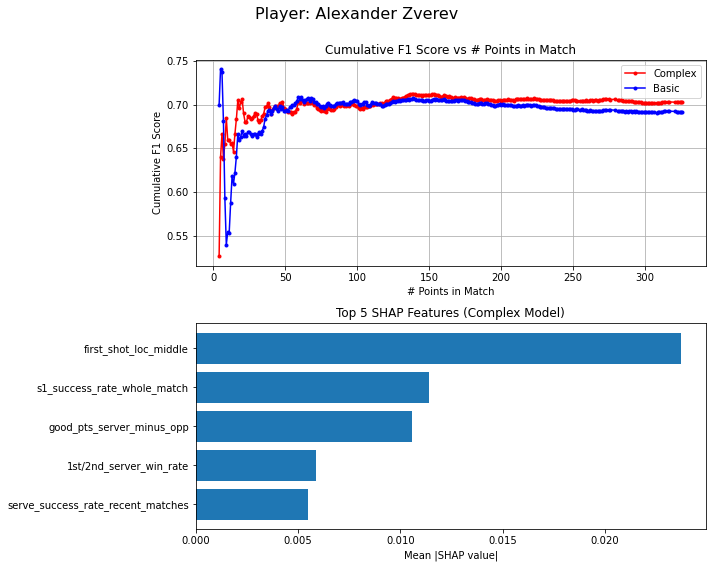

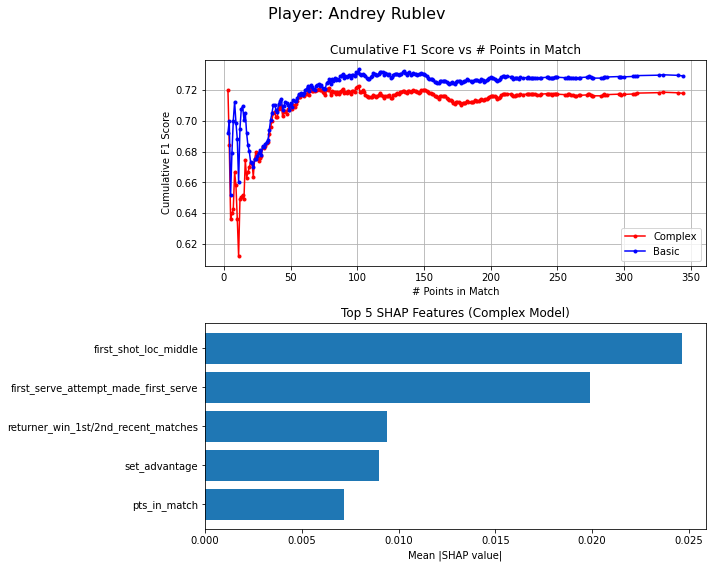

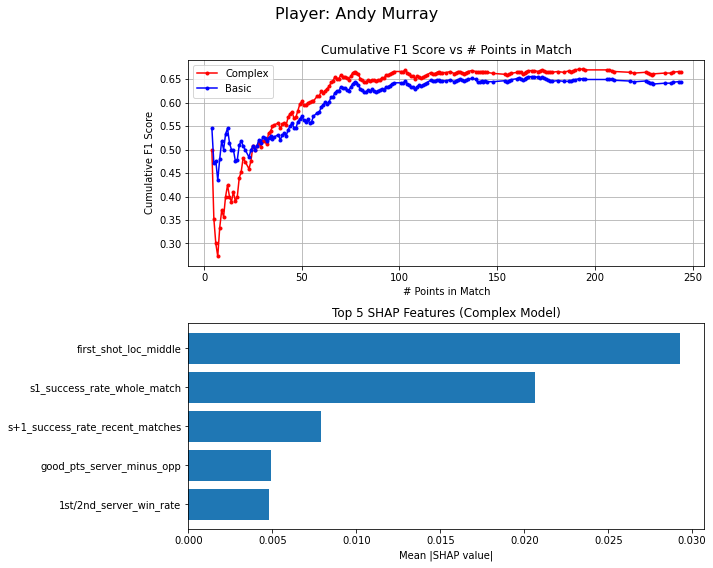

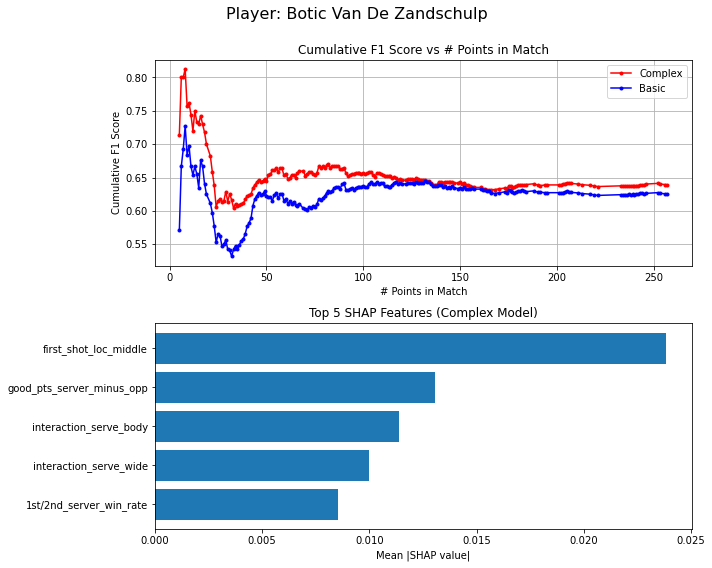

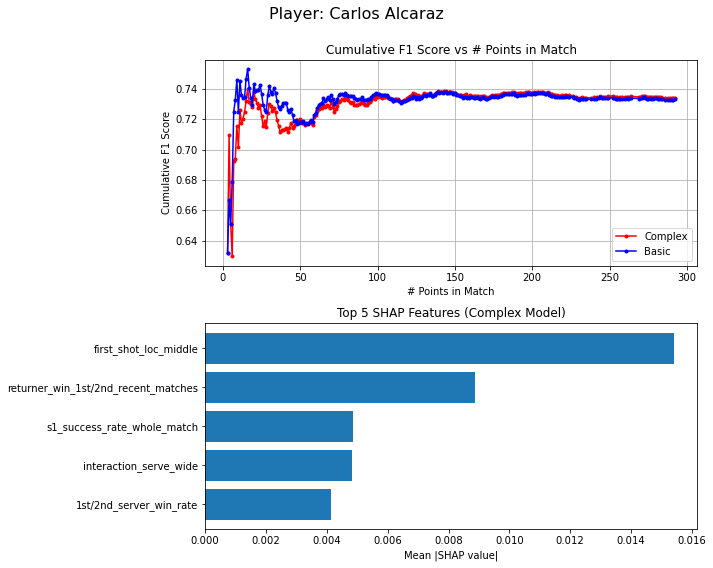

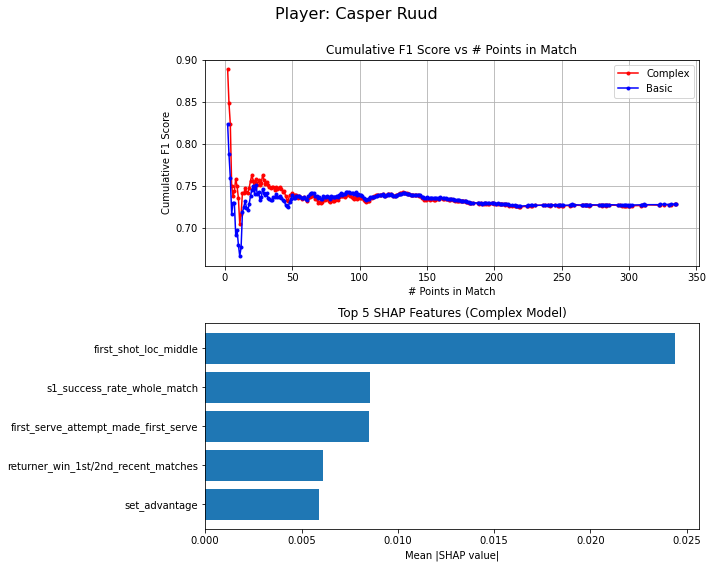

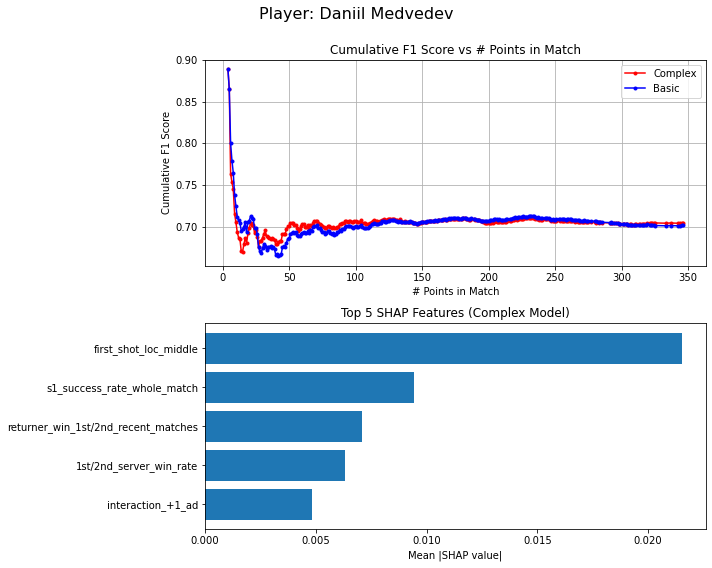

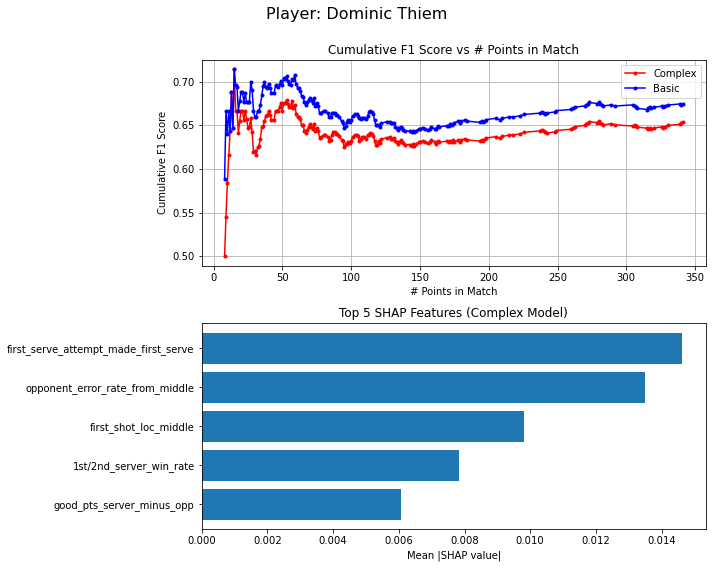

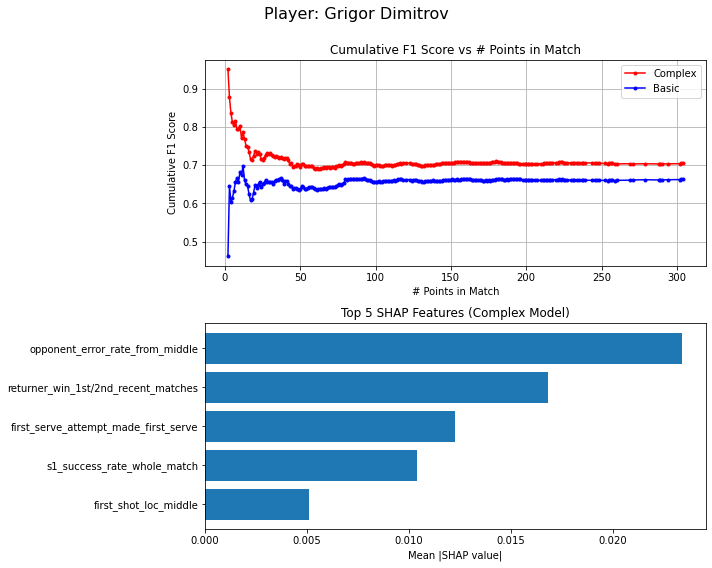

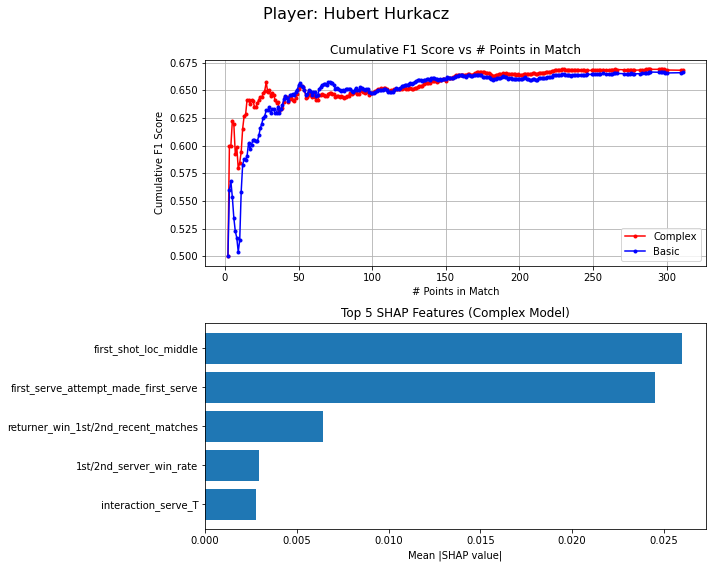

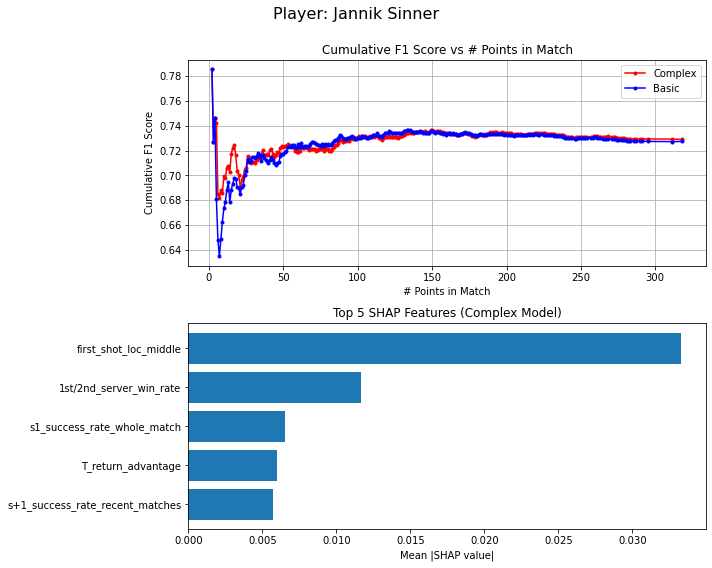

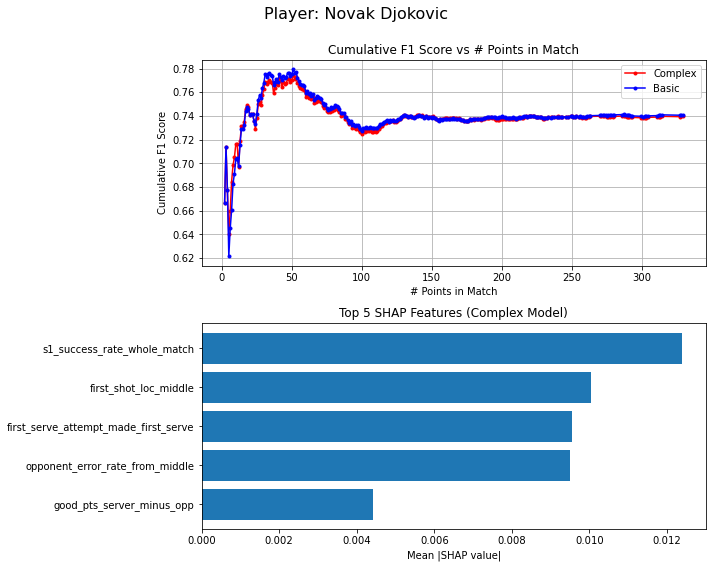

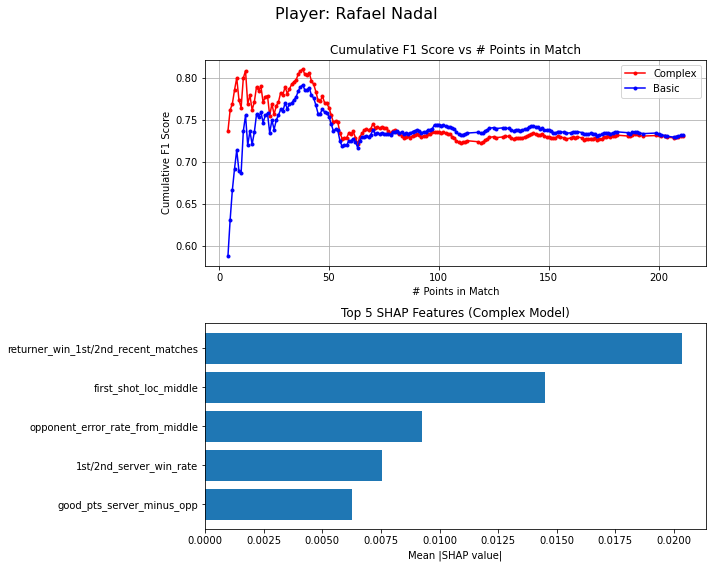

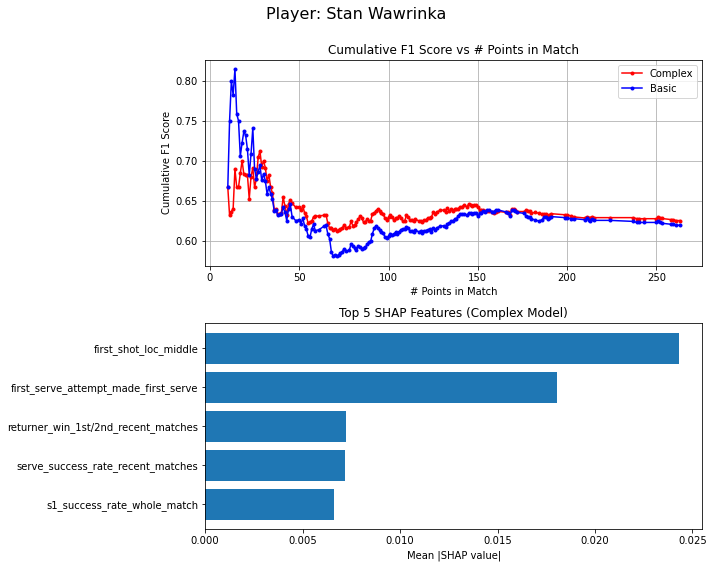

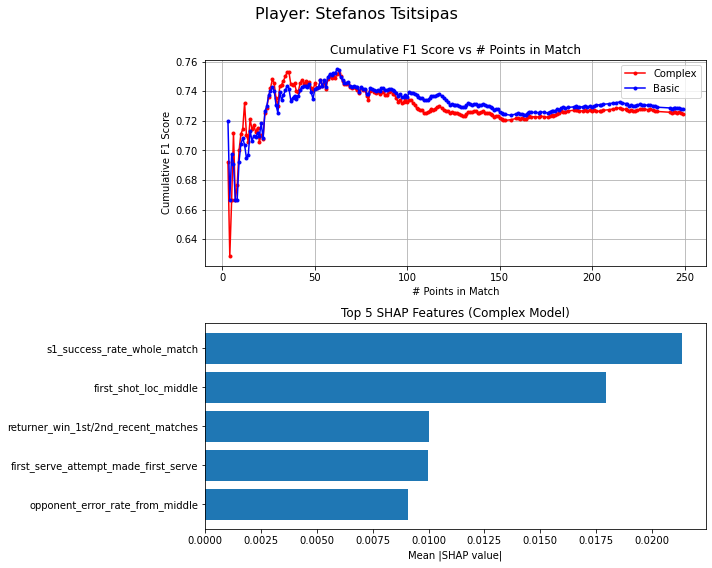

In [487]:
compare_f1_and_shap(models, results)

### Recommendation Quality Analysis

In [440]:
serve_locs = {'t', 'wide', 'body'}
shot_locs = {'deuce_court', 'ad_court', 'middle'}

def update_interactions(row, serve, shot, side, serve_type, is_basic=True):
    row = row.copy()
        
    # Vectorized one-hot encoding
    for loc in serve_locs:
        val = int(serve == loc)
        row[f'serve_loc_{loc}'] = val
        row[f'side_serve_loc_{loc}_on_{side}'] = val
        row[f'1st/2nd_serve_loc_{loc}_on_{side}_{serve_type}'] = val
    for loc in shot_locs:
        val = int(shot == loc)
        row[f'first_shot_loc_{loc}'] = val
        row[f'side_first_shot_loc_{loc}_on_{side}'] = val
        row[f'1st/2nd_first_shot_loc_{loc}_on_{side}_{serve_type}'] = val


    # Update interaction features
    if not is_basic:
        row['interaction_returns_wide'] = row['serve_loc_wide'] * row['wide_returner_win_recent_matches']
        row['interaction_returns_body'] = row['serve_loc_body'] * row['body_returner_win_recent_matches']
        row['interaction_returns_T'] = row['serve_loc_t'] * row['T_returner_win_recent_matches']

        row['interaction_+1_deuce'] = row['first_shot_loc_deuce_court'] * row['op_pct_errors_deuce_side']
        row['interaction_+1_ad'] = row['first_shot_loc_ad_court'] * row['op_pct_errors_ad_side']
        row['interaction_+1_middle'] = row['first_shot_loc_middle'] * row['op_pct_errors_middle']

        row['interaction_+1_deuce_shots'] = row['first_shot_loc_deuce_court'] * row['op_pct_shots_errors_deuce_side']
        row['interaction_+1_ad_shots'] = row['first_shot_loc_ad_court'] * row['op_pct_shots_errors_ad_side']
        row['interaction_+1_middle_shots'] = row['first_shot_loc_middle'] * row['op_pct_shots_errors_middle']

        row['interaction_serve_wide'] = row['serve_loc_wide'] * row['wide_server_win_rate']
        row['interaction_serve_body'] = row['serve_loc_body'] * row['body_server_win_rate']
        row['interaction_serve_T'] = row['serve_loc_t'] * row['T_server_win_rate']

        row['same_serve_last'] = int(serve == row['last_serve'])
        row['same_shot_last'] = int(shot == row['last_1_shot'])

        row['interaction_gp'] = row['is_game_point_True'] * row['server_gp_won_recent_matches']
        row['interaction_s+1_success_rate_history'] = row[f'win_pct_s1_{row["1st/2nd_s+1"]}']
        row['interaction_serve_success_rate_history'] = row[f'win_pct_serve_{row["1st/2nd_serve_loc"]}']
        row['interaction_first_shot_success_rate_history'] = row[f'win_pct_first_shot_{row["1st/2nd_first_shot_loc"]}']

    # Zero out s+1 columns more efficiently
    s1_cols = [col for col in row.index if col.startswith('s+1_')]
    side_s1_cols = [col for col in row.index if col.startswith('side_s+1_')]
    serve_type_s1_cols = [col for col in row.index if col.startswith('1st/2nd_s+1_')]

    row[s1_cols] = 0
    row[side_s1_cols] = 0
    row[serve_type_s1_cols] = 0

    row[f'side_s+1_{serve}_{shot}_{side}'] = 1
    row[f's+1_{serve}_{shot}'] = 1
    row[f'1st/2nd_s+1_{serve}_{shot}_{serve_type}_{side}'] = 1
    
    return row

def evaluate_recommendations(df, model, feature_cols, k=3, is_basic=True):
    results = []
    all_modified_rows = []
    meta_info = []

    sides_list = ['deuce' if row.court_side_deuce else 'ad' for row in df.itertuples()]

    
    for i, row in enumerate(df.itertuples()):
        base_row = df.iloc[i]
        side = sides_list[i]
        combos = list(product(serve_locs, shot_locs, [side]))

        actual_serve = next(loc for loc in serve_locs if getattr(row, f'serve_loc_{loc}') == 1)
        actual_shot = next(loc for loc in shot_locs if getattr(row, f'first_shot_loc_{loc}') == 1)
        actual_combo = (actual_serve, actual_shot, side)

        for serve, shot, side in combos:
            modified_row = update_interactions(base_row, serve, shot, side, row.serve_type, is_basic)
            all_modified_rows.append(modified_row[feature_cols])
            meta_info.append((i, (serve, shot, side), actual_combo, row.match_id, side, row.pts_in_match))

    # Batch prediction
    combo_df = pd.DataFrame(all_modified_rows)
    dmatrix = xgb.DMatrix(combo_df)
    all_probs = model.predict(combo_df)

    # Reconstruct results grouped by original row
    row_results = defaultdict(list)

    for prob, (row_idx, combo, actual_combo, _, side, _) in zip(all_probs, meta_info):
        row_results[row_idx].append((combo, prob))

    for row_idx, ranked_combos in row_results.items():
        sorted_combos = sorted(ranked_combos, key=lambda x: x[1], reverse=True)
        i_meta = meta_info[row_idx * len(serve_locs) * len(shot_locs)]  # any combo from the same point
        results.append({
            'match_id': i_meta[3],
            'side': i_meta[4],
            'point_index': i_meta[5],
            'actual_combo': i_meta[2],
            'probabilities': sorted_combos,
        })

    return results


In [442]:
results_recs = defaultdict(lambda: defaultdict(list))

for player in players_lst:
    print(player)

    res_basic = evaluate_recommendations(models[player]['df_test'], models[player]['basic'], feature_cols_basic, is_basic=True)
    res_complex = evaluate_recommendations(models[player]['df_test'], models[player]['complex'], feature_cols_complex, is_basic=False)

    results_recs[player]['basic'] = res_basic
    results_recs[player]['complex'] = res_complex

alexander_zverev
andrey_rublev
andy_murray
botic_van_de_zandschulp
carlos_alcaraz
casper_ruud
daniil_medvedev
dominic_thiem
grigor_dimitrov
hubert_hurkacz
jannik_sinner
novak_djokovic
rafael_nadal
stan_wawrinka
stefanos_tsitsipas


In [443]:
def coefficient_of_variation(probabilities):
    probs = np.array([p[1] for p in probabilities])
    return np.std(probs) / np.mean(probs)

def evaluate_recommendation_quality(res, top_k=3):
    results = defaultdict(lambda: {
        'top1_hits': 0,
        'top3_hits': 0,
        'total': 0,
        'entropy_list': [],
        'top1_combo_counts': defaultdict(int),
        'streak_len_serves': [1],
        'streak_len_1s': [1],
        'min_max_prob': [],
        'match_top2_counts': defaultdict(Counter)
    })

    curr_match = None
    curr_serve_streak = {'deuce': 'none', 'ad': 'none'}
    curr_1_streak = {'deuce': 'none', 'ad': 'none'}

    for point in res:
        side = point['side']
        actual_combo = point['actual_combo']
        ranked_combos = point['probabilities']
        match_id = point['match_id']

        if match_id != curr_match:
            curr_match = match_id
            curr_serve_streak = {'deuce': 'none', 'ad': 'none'}
            curr_1_streak = {'deuce': 'none', 'ad': 'none'}
            results[side]['streak_len_serves'].append(1)
            results[side]['streak_len_1s'].append(1)

        top_k_combos = [combo for combo, _ in ranked_combos[:top_k]]
        top1_combo = ranked_combos[0][0]
        top2_combos = [combo for combo, _ in ranked_combos[:2]]
        results[side]['match_top2_counts'][(match_id, side)].update(top2_combos)

        results[side]['min_max_prob'].append([0, 0])
        results[side]['min_max_prob'][-1][1] = max(ranked_combos, key=lambda x: x[1])[1]
        results[side]['min_max_prob'][-1][0] = min(ranked_combos, key=lambda x: x[1])[1]

        top_combo_serve, top_combo_shot, _ = top1_combo

        if top_combo_serve == curr_serve_streak[side]:
            results[side]['streak_len_serves'][-1] += 1
        else:
            curr_serve_streak[side] = top_combo_serve
            results[side]['streak_len_serves'].append(1)

        if top_combo_shot == curr_1_streak[side]:
            results[side]['streak_len_1s'][-1] += 1
        else:
            curr_1_streak[side] = top_combo_shot
            results[side]['streak_len_1s'].append(1)

        results[side]['total'] += 1
        if actual_combo == top1_combo:
            results[side]['top1_hits'] += 1
        if actual_combo in top_k_combos:
            results[side]['top3_hits'] += 1

        prob_entropy = coefficient_of_variation(ranked_combos)
        results[side]['entropy_list'].append(prob_entropy)
        results[side]['top1_combo_counts'][top1_combo] += 1

    summary = {}
    for side, r in results.items():
        total = r['total']
        match_keys = list(r['match_top2_counts'].keys())
        combo_vocab = sorted({combo for counter in r['match_top2_counts'].values() for combo in counter})
        combo_index = {combo: i for i, combo in enumerate(combo_vocab)}

        match_vectors = []
        for key in match_keys:
            combo_counts = r['match_top2_counts'][key]
            vec = np.zeros(len(combo_vocab))
            for combo, count in combo_counts.items():
                vec[combo_index[combo]] = count
            match_vectors.append(vec)

        if len(match_vectors) > 1:
            sim_matrix = cosine_similarity(match_vectors)
            dissim_values = 1 - sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
            avg_cosine_dissim = np.mean(dissim_values)
        else:
            avg_cosine_dissim = 0

        summary[side] = {
            'Top-1 Accuracy': r['top1_hits'] / total if total > 0 else 0,
            'Top-3 Accuracy': r['top3_hits'] / total if total > 0 else 0,
            'Average CV': np.mean(r['entropy_list']) if r['entropy_list'] else 0,
            'Top-1 Combo Distribution': dict(sorted(r['top1_combo_counts'].items(), key=lambda x: -x[1])),
            'Median Serve Streak': np.median(r['streak_len_serves']),
            'Median +1 Shot Streak': np.median(r['streak_len_1s']),
            'Min Max Prob': (np.mean([p[0] for p in r['min_max_prob']]), np.mean([p[1] for p in r['min_max_prob']])),
            'Avg Cosine Dissimilarity (Top-2 Counts Between Matches)': round(avg_cosine_dissim, 3)
        }

    return summary

In [445]:
rec_quality = defaultdict(lambda: defaultdict(dict))

for player in results_recs.keys():
    rec_quality[player]['basic'] = evaluate_recommendation_quality(results_recs[player]['basic'])
    rec_quality[player]['complex'] = evaluate_recommendation_quality(results_recs[player]['complex'])

In [448]:
def calculate_differences(stats_dict):
    """
    Calculate the differences between basic and complex models for each player and side
    Returns a nested dictionary with the differences
    """
    differences = defaultdict(dict)
    
    for player, player_data in stats_dict.items():
        differences[player] = {}
        for side in ['deuce', 'ad']:
            basic_data = player_data['basic'][side]
            complex_data = player_data['complex'][side]
            
            diff = {
                'Top-1 Accuracy Diff': complex_data['Top-1 Accuracy'] - basic_data['Top-1 Accuracy'],
                'Top-3 Accuracy Diff': complex_data['Top-3 Accuracy'] - basic_data['Top-3 Accuracy'],
                'CV Diff': complex_data['Average CV'] - basic_data['Average CV'],
                'Median Serve Streak Diff': complex_data['Median Serve Streak'] - basic_data['Median Serve Streak'],
                'Median +1 Shot Streak Diff': complex_data['Median +1 Shot Streak'] - basic_data['Median +1 Shot Streak']
            }
            differences[player][side] = diff
    
    return differences

def create_comparison_dataframe(stats_dict):
    """
    Create a pandas DataFrame comparing basic vs complex metrics for all players
    """
    rows = []
    
    for player, player_data in stats_dict.items():
        for side in ['deuce', 'ad']:
            basic = player_data['basic'][side]
            complex = player_data['complex'][side]
            
            min_prob_basic, max_prob_basic = basic.get('Min Max Prob', (0, 0))
            min_prob_complex, max_prob_complex = complex.get('Min Max Prob', (0, 0))

            rows.append({
                'Player': player,
                'Side': side,
                'Model': 'Basic',
                'Top-1 Accuracy': basic['Top-1 Accuracy'],
                'Top-3 Accuracy': basic['Top-3 Accuracy'],
                'Average CV': basic['Average CV'],
                'Median Serve Streak': basic['Median Serve Streak'],
                'Median +1 Shot Streak': basic['Median +1 Shot Streak'],
                'Avg Cosine Dissimilarity': basic['Avg Cosine Dissimilarity (Top-2 Counts Between Matches)'],
                'Average Min Pred': min_prob_basic,
                'Average Max Pred': max_prob_basic
            })

            rows.append({
                'Player': player,
                'Side': side,
                'Model': 'Complex',
                'Top-1 Accuracy': complex['Top-1 Accuracy'],
                'Top-3 Accuracy': complex['Top-3 Accuracy'],
                'Average CV': complex['Average CV'],
                'Median Serve Streak': complex['Median Serve Streak'],
                'Median +1 Shot Streak': complex['Median +1 Shot Streak'],
                'Avg Cosine Dissimilarity': complex['Avg Cosine Dissimilarity (Top-2 Counts Between Matches)'],
                'Average Min Pred': min_prob_complex,
                'Average Max Pred': max_prob_complex
            })

    
    return pd.DataFrame(rows)

def plot_comparison(df, metric, title=None, player_order=None):
    """Modified version without error bars"""
    plt.figure(figsize=(14, 6))

    if player_order is not None:
        df['Player'] = pd.Categorical(df['Player'], categories=player_order, ordered=True)

    sns.barplot(
        data=df,
        x='Player', y=metric, hue='Model',
        hue_order=['Basic', 'Complex'],
        palette={'Basic': 'skyblue', 'Complex': 'salmon'},
        ci=None
    )

    plt.title(title if title else f'Comparison of {metric}', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(fontsize=12, title_fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('', fontsize=13)
    plt.ylabel(metric, fontsize=13)
    plt.tight_layout()
    plt.show()

def prepare_min_max_spread_df(df):
    """
    Combine 'deuce' and 'ad' sides by averaging min and max predictions per player and model.
    """
    agg_df = (
        df.groupby(['Player', 'Model'])
          .agg({
              'Average Min Pred': 'median',
              'Average Max Pred': 'median'
          })
          .reset_index()
    )
    agg_df['Label'] = agg_df['Player']
    return agg_df

def plot_min_max_spread_bar(df, player_order=None):
    """
    Plot min-max predicted probability ranges per model, combined across sides.
    Bars are grouped by player and colored by model type. Font sizes are consistent with other plots.
    """

    # Combine sides by averaging min/max per player + model
    spread_df = (
    df.groupby(['Player', 'Model'])
      .agg({'Average Min Pred': 'mean', 'Average Max Pred': 'mean'})
      .reset_index()
    ) 

    if player_order is not None:
        spread_df['Player'] = pd.Categorical(spread_df['Player'], categories=player_order, ordered=True)
        spread_df = spread_df.sort_values('Player')

    players = spread_df['Player'].unique()

    model_offsets = {'Basic': -0.12, 'Complex': 0.12}
    colors = {'Basic': 'skyblue', 'Complex': 'salmon'}

    plt.figure(figsize=(14, 6))
    for i, player in enumerate(players):
        for _, row in spread_df[spread_df['Player'] == player].iterrows():
            x = i + model_offsets[row['Model']]
            plt.plot(
                [x, x],
                [row['Average Min Pred'], row['Average Max Pred']],
                color=colors[row['Model']],
                linewidth=13,
                solid_capstyle='butt'
            )

    plt.xticks(
        ticks=range(len(players)),
        labels=players,
        rotation=45,
        ha='right',
        fontsize=14
    )
    plt.yticks(fontsize=12)
    plt.ylabel('Predicted Probability', fontsize=13)
    plt.xlabel('Player', fontsize=13)
    plt.title('Prediction Range (Avg. Min and Max Prediction Probability)', fontsize=14)
    plt.legend(

        handles=[
            plt.Line2D([0], [0], color='skyblue', lw=10, label='Basic'),
            plt.Line2D([0], [0], color='salmon', lw=10, label='Complex')
        ],
        fontsize=12,
        title_fontsize=12
    )
    plt.tight_layout()
    plt.show()

def plot_cosine_dissim_dumbbell(df, player_order=None):
    # Aggregate across 'deuce' and 'ad' sides by player and model
    df_agg = (
        df.groupby(['Player', 'Model'])['Avg Cosine Dissimilarity']
          .mean()
          .unstack()
          .dropna()
    )

    if player_order:
        df_agg = df_agg.loc[player_order]

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, player in enumerate(df_agg.index):
        x1 = df_agg.loc[player, 'Basic']
        x2 = df_agg.loc[player, 'Complex']
        ax.plot([x1, x2], [i, i], color='gray', lw=2)
        ax.scatter(x1, i, color='skyblue', s=100, label='Basic' if i == 0 else "")
        ax.scatter(x2, i, color='salmon', s=100, label='Complex' if i == 0 else "")

    ax.set_yticks(range(len(df_agg)))
    ax.set_yticklabels(df_agg.index, fontsize = 12)
    ax.set_xlabel('Avg Cosine Dissimilarity', fontsize = 12)
    ax.set_title('Dissimilarity of Top-2 Recommendations Between Matches', fontsize=14)
    ax.legend(fontsize = 12)
    plt.tight_layout()
    plt.show()


def plot_player_combo_distribution(stats_dict, player):
    """
    Visualize only the combo distributions for a specific player
    Compares basic vs complex models for both deuce and ad sides
    """
    player_data = stats_dict[player]
    player_name = player.replace("_", " ").title()
    
    sides = [side for side in ['deuce', 'ad'] if side in player_data['basic']]
    
    # Create figure with subplots for each side
    _, axes = plt.subplots(len(sides), 2, figsize=(16, 6*len(sides)))
    if len(sides) == 1:
        axes = axes.reshape(1, 2)  # Ensure 2D array for single side
    
    for i, side in enumerate(sides):
        # Basic model combo distribution
        basic_combos = player_data['basic'][side]['Top-1 Combo Distribution']
        basic_df = pd.DataFrame.from_dict(basic_combos, orient='index', columns=['Count'])
        basic_df.index = basic_df.index.map(lambda x: f"{x[0].upper()} serve → {x[1].replace('_', ' ')}")
        basic_df = basic_df.sort_values('Count', ascending=False)
        
        ax = axes[i, 0] if len(sides) > 1 else axes[0]
        sns.barplot(x=basic_df.index, y=basic_df['Count'], ax=ax, palette='Blues_d')
        ax.set_title(f'{player_name} - Basic Model ({side.title()} Side)', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=13)
        ax.set_xlabel('')
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
        # Complex model combo distribution
        complex_combos = player_data['complex'][side]['Top-1 Combo Distribution']
        complex_df = pd.DataFrame.from_dict(complex_combos, orient='index', columns=['Count'])
        complex_df.index = complex_df.index.map(lambda x: f"{x[0].upper()} serve → {x[1].replace('_', ' ')}")
        complex_df = complex_df.sort_values('Count', ascending=False)
        
        ax = axes[i, 1] if len(sides) > 1 else axes[1]
        sns.barplot(x=complex_df.index, y=complex_df['Count'], ax=ax, palette='Reds_d')
        ax.set_title(f'{player_name} - Complex Model ({side.title()} Side)', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=13)
        ax.set_xlabel('')
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
        # Rotate x-labels
        for j in range(2):
            ax = axes[i, j] if len(sides) > 1 else axes[j]
            plt.sca(ax)
            plt.xticks(rotation=45, ha='right', fontsize=13)
    
    plt.tight_layout()
    plt.show()

def analyze_recommendation_quality(stats_dict):
    """
    Full analysis pipeline:
    1. Calculate differences
    2. Create comparison DataFrame
    3. Generate visualizations
    """
    # Calculate differences
    differences = calculate_differences(stats_dict)
    
    # Create comparison DataFrame
    comparison_df = create_comparison_dataframe(stats_dict)
    player_order = sorted(comparison_df['Player'].unique())
    
    # Generate plots for key metrics
    plot_comparison(comparison_df, 'Top-1 Accuracy', 'Freq. of Actual Combo = Top-1 Recommendation', player_order)
    plot_comparison(comparison_df, 'Top-3 Accuracy', 'Freq. of Actual Combo = Top-3 Recommendation', player_order)
    plot_comparison(comparison_df, 'Average CV', 'Avg. Coefficient of Variation (CV) Scores', player_order)
    plot_comparison(comparison_df, 'Median Serve Streak', 'Median Serve Streak', player_order)
    plot_comparison(comparison_df, 'Median +1 Shot Streak', 'Median +1 Shot Streak', player_order)
    plot_cosine_dissim_dumbbell(comparison_df, player_order)
    plot_min_max_spread_bar(comparison_df, player_order)

    players = random.sample(list(stats_dict.keys()), 5)
    for player in players:
        plot_player_combo_distribution(stats_dict, player)
    
    return differences, comparison_df

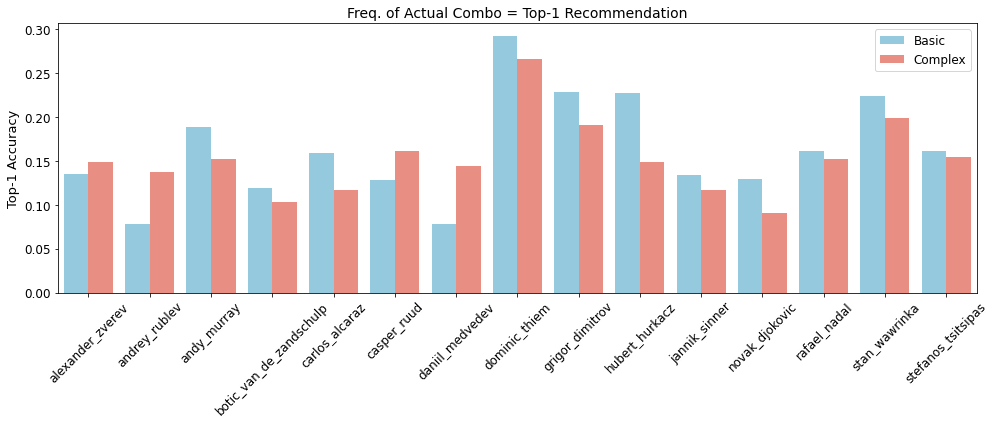

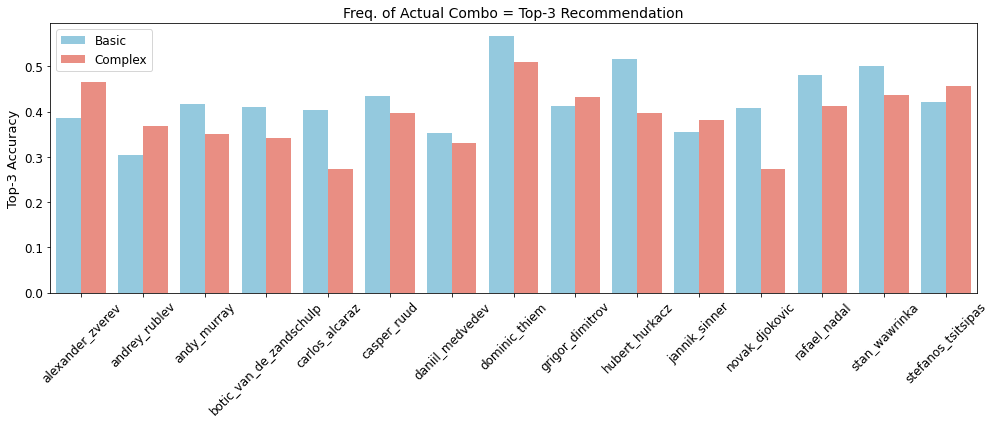

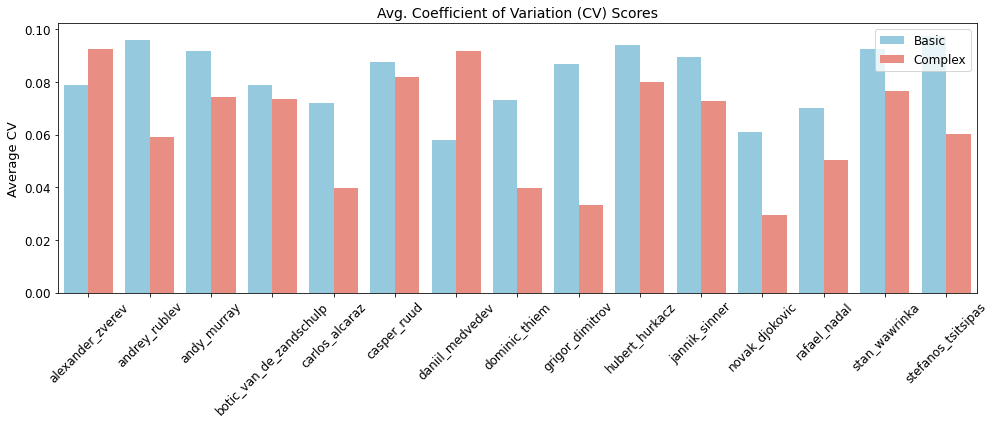

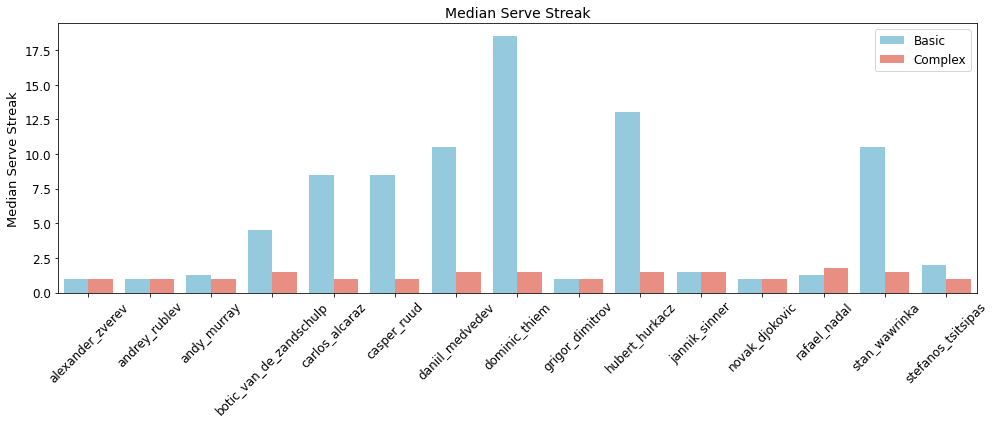

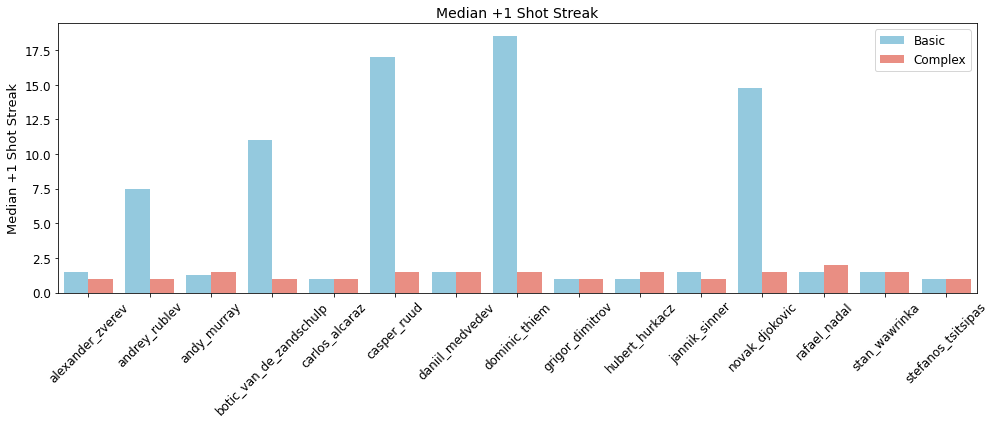

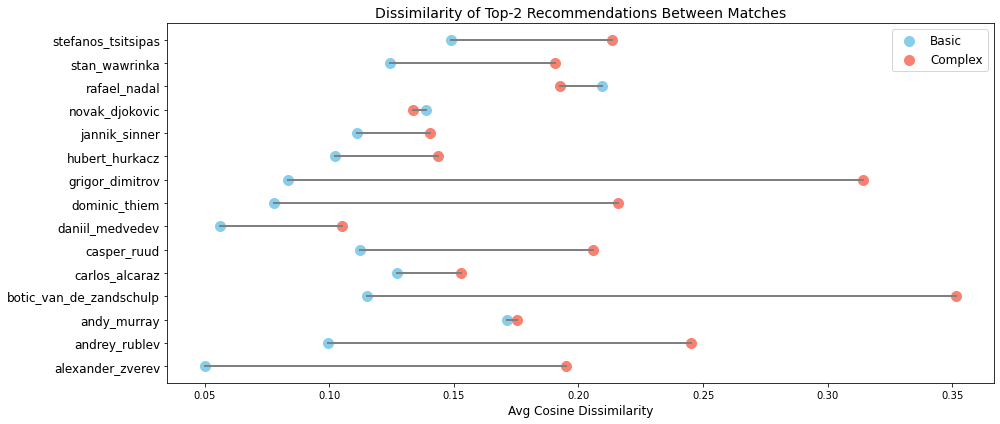

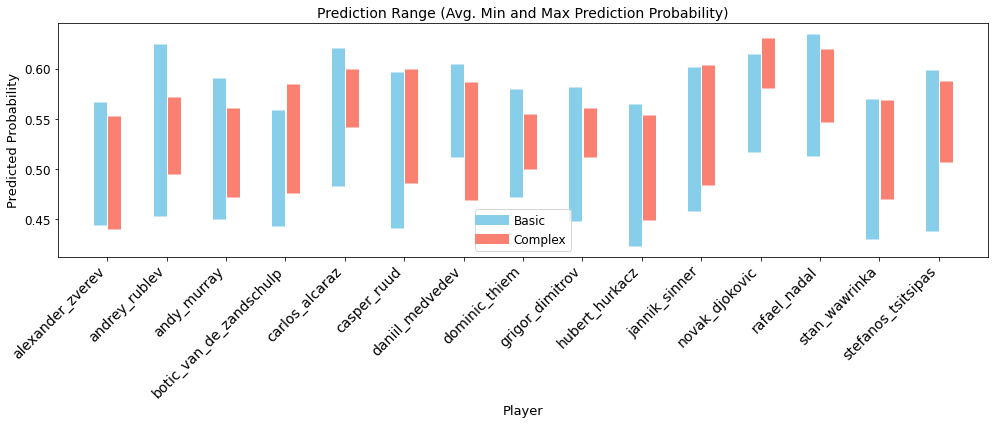

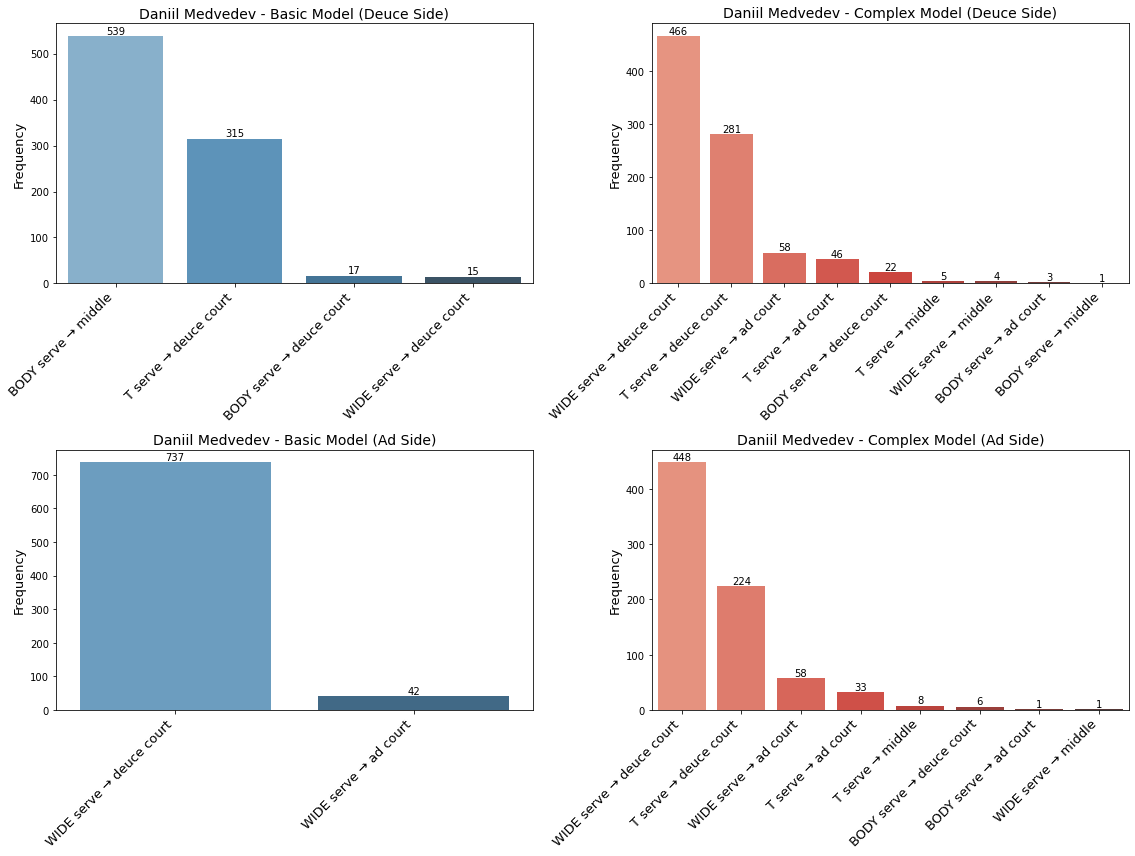

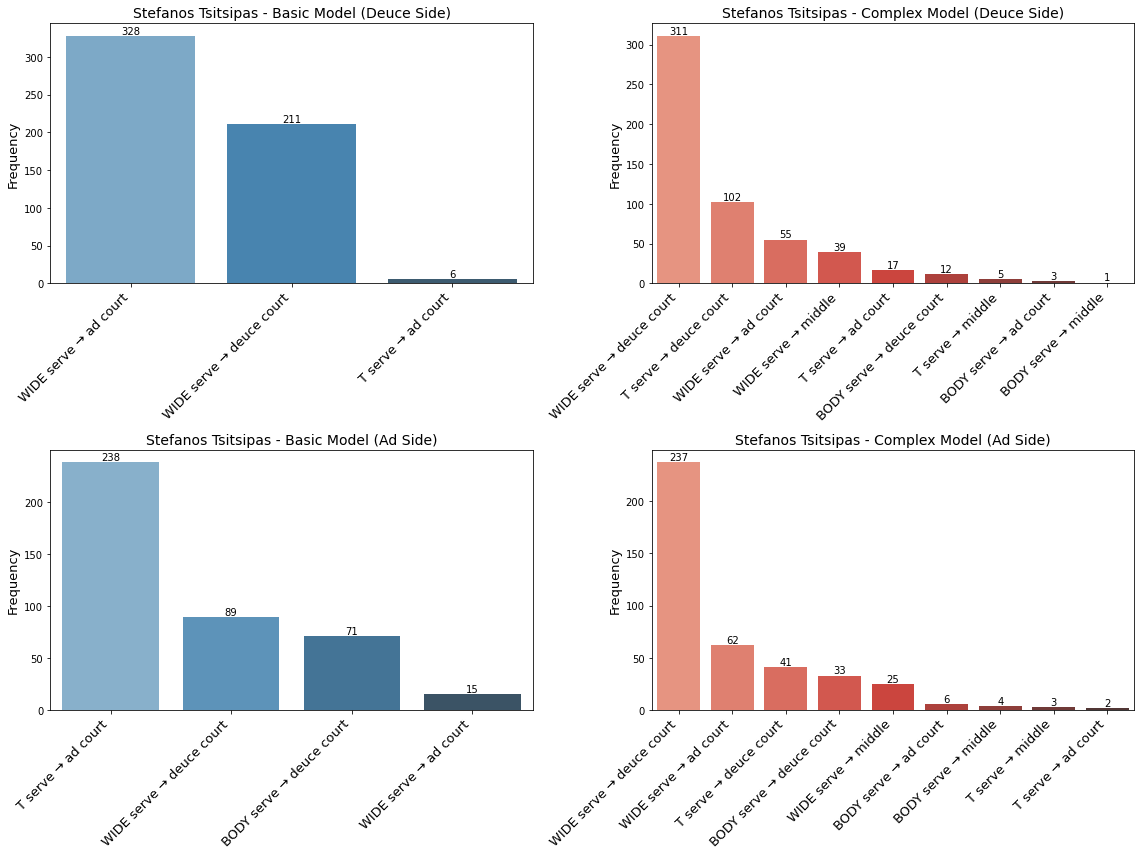

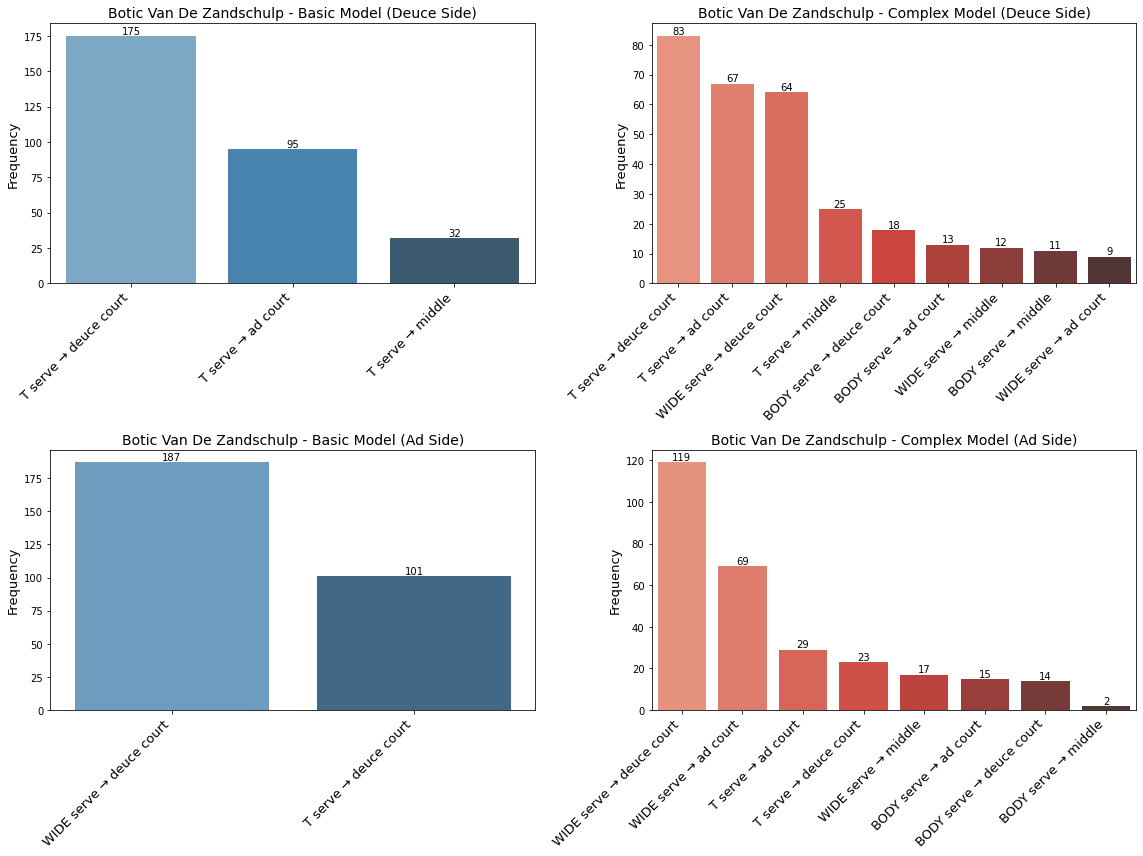

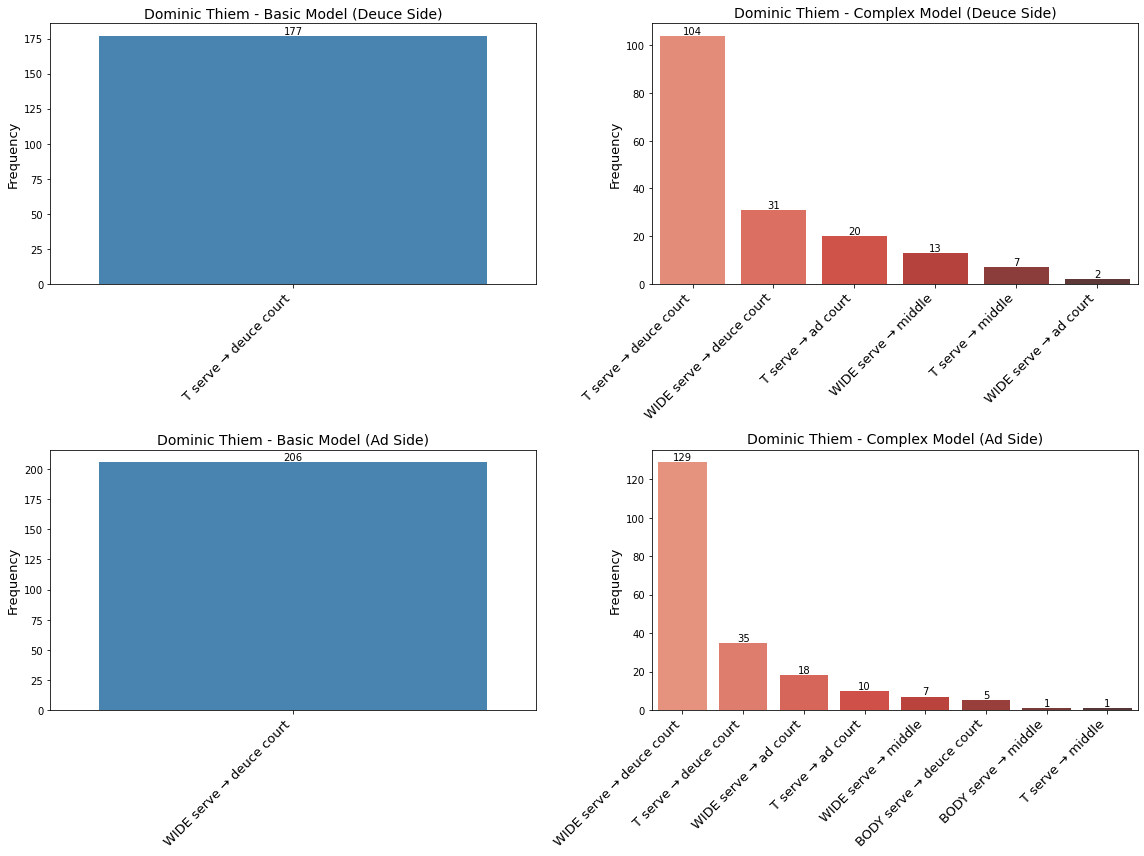

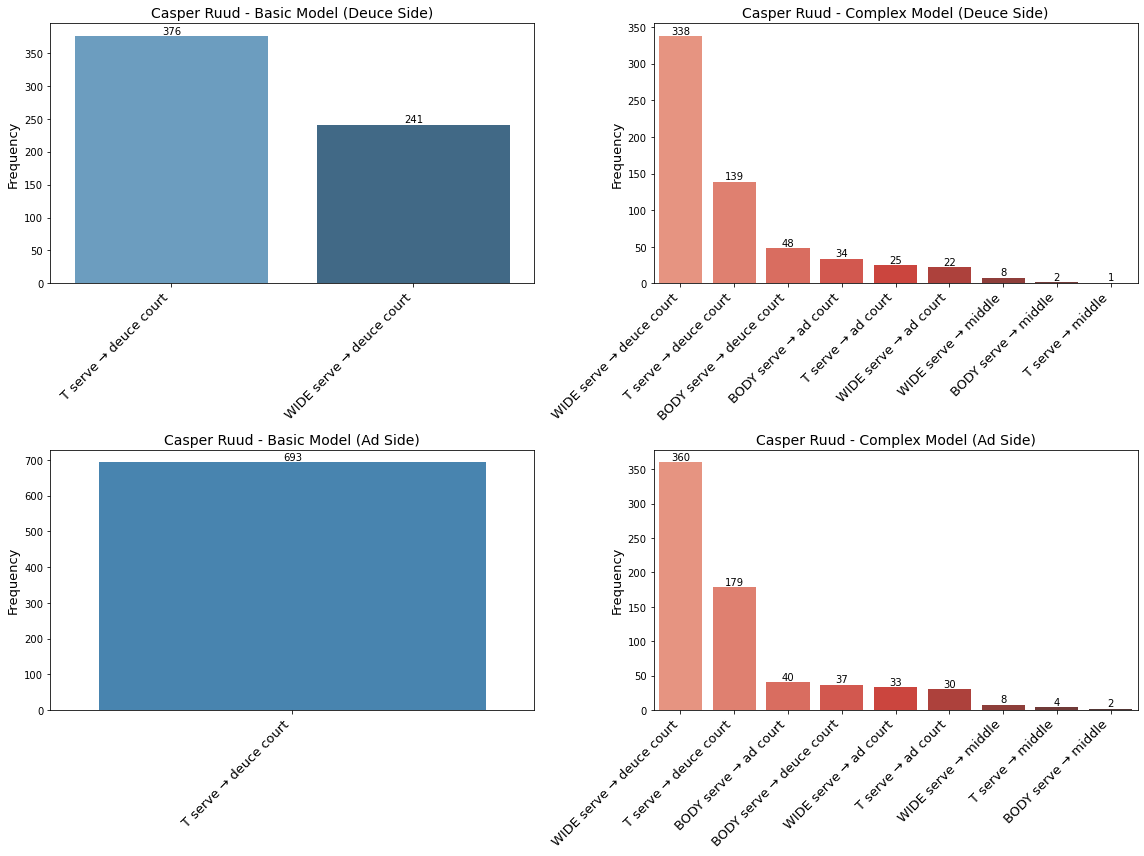

In [452]:
random_sample = random.sample(list(results_recs.keys()), 15)
rec_quality_sample = {k:v for k,v in rec_quality.items() if k in random_sample}
differences, comparison_df = analyze_recommendation_quality(rec_quality_sample)